# Import necessary libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

## Load datasets from Google Drive

In [ ]:
base_path = "/content/drive/MyDrive/Design_Project/"

# Load each dataset
lfs_month = pd.read_csv(base_path + "lfs_month.csv")
lfs_month_sa = pd.read_csv(base_path + "lfs_month_sa.csv")
lfs_month_youth = pd.read_csv(base_path + "lfs_month_youth.csv")
lfs_month_duration = pd.read_csv(base_path + "lfs_month_duration.csv")
lfs_month_status = pd.read_csv(base_path + "lfs_month_status.csv")

# Display basic information about the datasets
print("Datasets loaded successfully!")

Datasets loaded successfully!


## Statistical Properties Analysis


------------------------------------------------------------
Statistical Properties Analysis: Overall Unemployment Rate
------------------------------------------------------------

Descriptive Statistics:
           u_rate
count  182.000000
mean     3.436813
std      0.525396
min      2.600000
25%      3.125000
50%      3.300000
75%      3.500000
max      5.300000

Stationarity Check - Rolling Mean and Std:


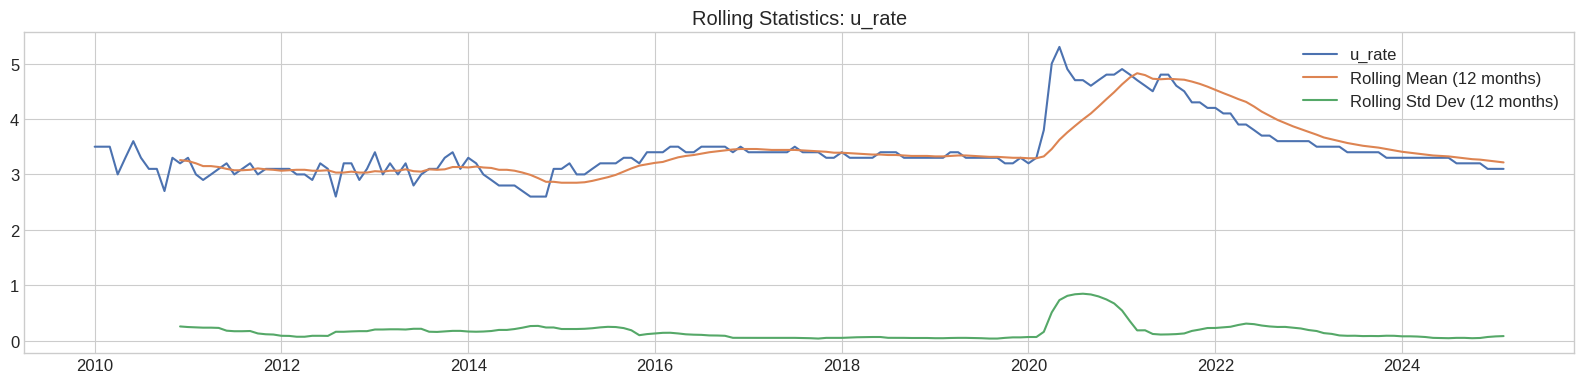


------------------------------------------------------------
Statistical Properties Analysis: Youth Unemployment Rates
------------------------------------------------------------

Descriptive Statistics:
       u_rate_15_24  u_rate_15_30
count    110.000000    110.000000
mean      11.496364      7.248182
std        1.264978      0.937078
min        9.000000      5.700000
25%       10.500000      6.600000
50%       11.200000      6.900000
75%       12.200000      7.475000
max       14.200000     10.000000

Stationarity Check - Rolling Mean and Std:


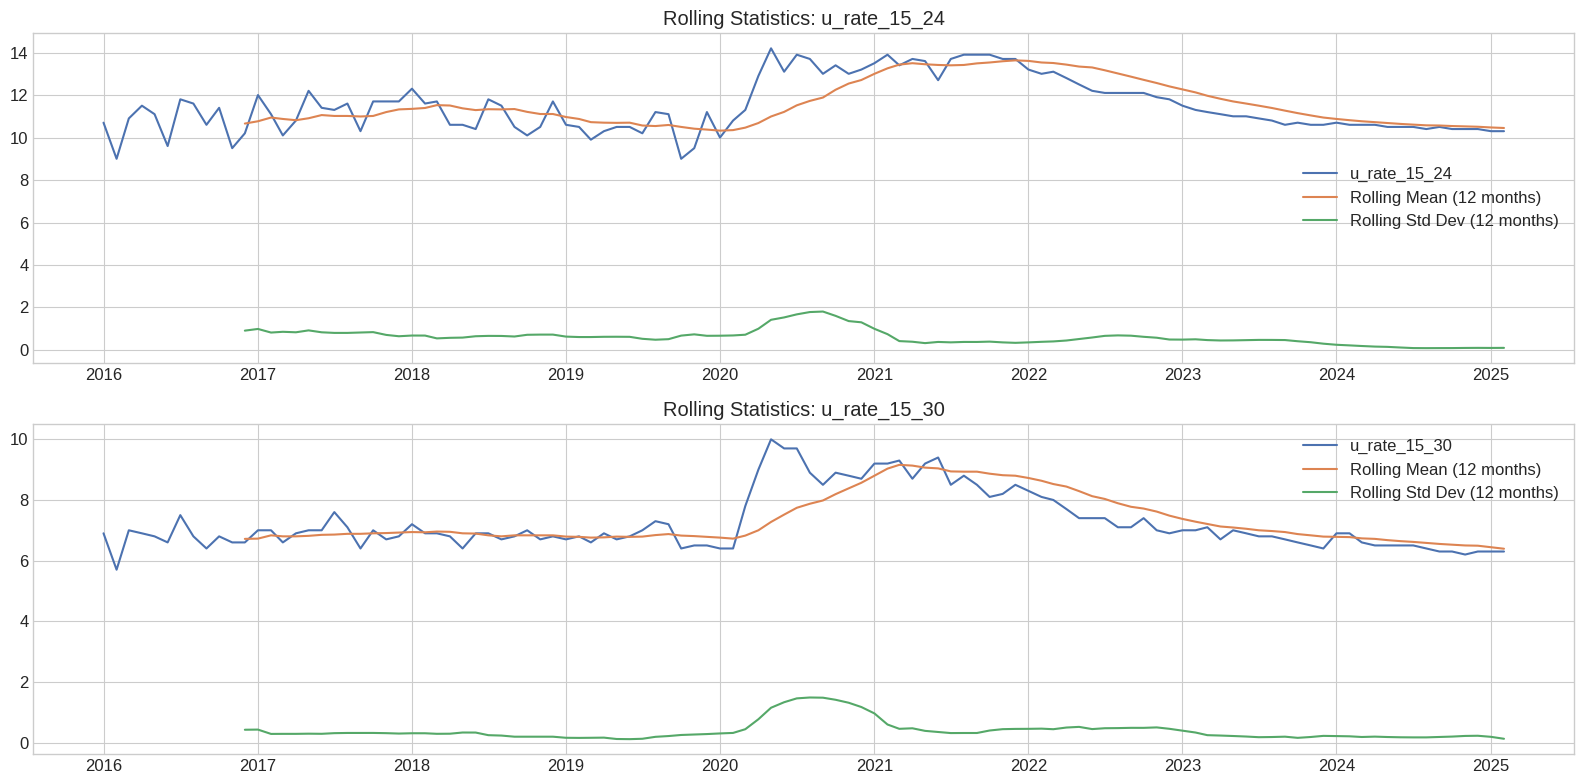


------------------------------------------------------------
Statistical Properties Analysis: Seasonally Adjusted Unemployment Rate
------------------------------------------------------------

Descriptive Statistics:
           u_rate
count  182.000000
mean     3.436264
std      0.522957
min      2.600000
25%      3.125000
50%      3.300000
75%      3.500000
max      5.200000

Stationarity Check - Rolling Mean and Std:


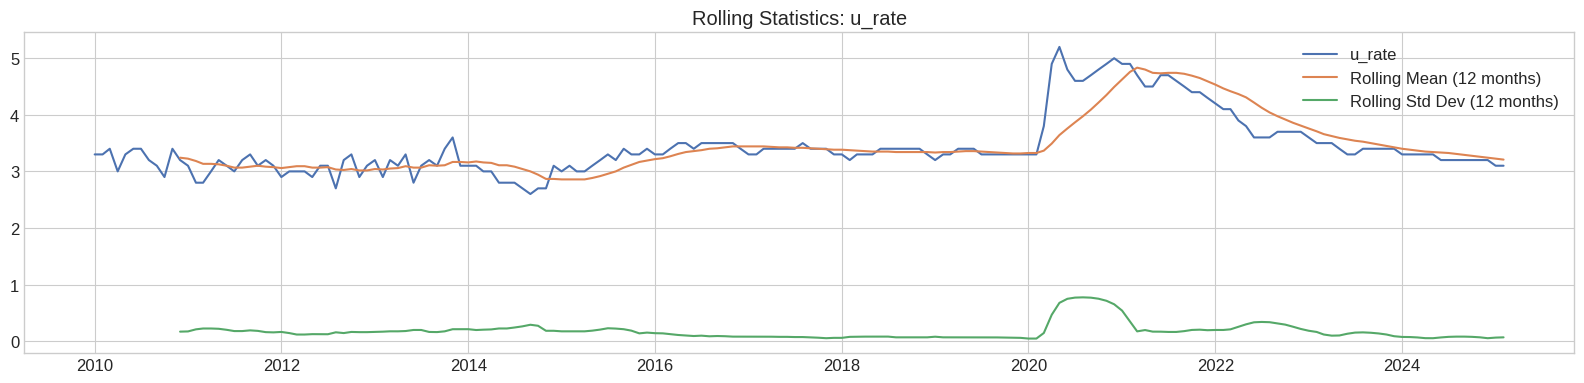

In [ ]:

def analyze_statistical_properties(df, title):
    """Analyze statistical properties of time series data"""
    print(f"\n{'-'*60}")
    print(f"Statistical Properties Analysis: {title}")
    print(f"{'-'*60}")

    # Descriptive statistics
    print("\nDescriptive Statistics:")
    print(df.describe())

    # Check for stationarity (basic visual check)
    print("\nStationarity Check - Rolling Mean and Std:")

    # Create figure
    fig, axes = plt.subplots(len(df.columns), 1, figsize=(16, 4*len(df.columns)))
    if len(df.columns) == 1:
        axes = [axes]

    for i, column in enumerate(df.columns):
        # Calculate rolling statistics
        rolling_mean = df[column].rolling(window=12).mean()
        rolling_std = df[column].rolling(window=12).std()

        # Plot original series and rolling statistics
        axes[i].plot(df.index, df[column], label=column)
        axes[i].plot(df.index, rolling_mean, label='Rolling Mean (12 months)')
        axes[i].plot(df.index, rolling_std, label='Rolling Std Dev (12 months)')
        axes[i].set_title(f"Rolling Statistics: {column}")
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

    return

# Analyze key datasets
analyze_statistical_properties(lfs_month_ts[['u_rate']], 'Overall Unemployment Rate')
analyze_statistical_properties(lfs_month_youth_ts[['u_rate_15_24', 'u_rate_15_30']], 'Youth Unemployment Rates')
analyze_statistical_properties(lfs_month_sa_ts[['u_rate']], 'Seasonally Adjusted Unemployment Rate')

## Feature Engineering Exploration

In [ ]:
from sklearn.preprocessing import StandardScaler

def engineer_time_series_features(df, target_col, lags=[1, 3, 6, 12], window_sizes=[3, 6, 12]):
    """
    Engineer features for time series modeling:
    - Lag features
    - Date-related features
    - Rolling statistics
    """
   
    df_features = df.copy()

   
    for lag in lags:
        df_features[f'{target_col}_lag_{lag}'] = df_features[target_col].shift(lag)

     # Extract date-related features
    df_features['month'] = df_features.index.month
    df_features['quarter'] = df_features.index.quarter
    df_features['year'] = df_features.index.year

    # One-hot encode month and quarter
    month_dummies = pd.get_dummies(df_features['month'], prefix='month', drop_first=True)
    quarter_dummies = pd.get_dummies(df_features['quarter'], prefix='quarter', drop_first=True)
    df_features = pd.concat([df_features, month_dummies, quarter_dummies], axis=1)

    #  Calculate rolling statistics
    for window in window_sizes:
        df_features[f'{target_col}_rolling_mean_{window}'] = df_features[target_col].rolling(window=window).mean()
        df_features[f'{target_col}_rolling_std_{window}'] = df_features[target_col].rolling(window=window).std()
        df_features[f'{target_col}_rolling_min_{window}'] = df_features[target_col].rolling(window=window).min()
        df_features[f'{target_col}_rolling_max_{window}'] = df_features[target_col].rolling(window=window).max()

    #  Calculate difference features (1st order difference)
    df_features[f'{target_col}_diff_1'] = df_features[target_col].diff(1)

    #  Calculate percentage change
    df_features[f'{target_col}_pct_change'] = df_features[target_col].pct_change()

    # Drop rows with NaN values after feature engineering
    df_features_clean = df_features.dropna()

    # Standardize numerical features except for target, one-hot encoded, and date identifiers
    scaler = StandardScaler()
    cols_to_standardize = [col for col in df_features_clean.columns
                         if col != target_col
                         and not col.startswith('month_')
                         and not col.startswith('quarter_')
                         and col not in ['month', 'quarter', 'year']]

    if cols_to_standardize:
        df_features_clean[cols_to_standardize] = scaler.fit_transform(df_features_clean[cols_to_standardize])

    print(f"Feature engineering created {df_features_clean.shape[1]} features from {df.shape[1]} original features")
    print(f"Rows reduced from {df.shape[0]} to {df_features_clean.shape[0]} after removing NaN values")

    return df_features_clean

# Engineer features for unemployment rate
features_overall = engineer_time_series_features(lfs_month_ts, 'u_rate')
features_youth = engineer_time_series_features(lfs_month_youth_ts, 'u_rate_15_24')
features_sa = engineer_time_series_features(lfs_month_sa_ts, 'u_rate')

# Display the first few rows of engineered features
print("\nSample of engineered features for overall unemployment rate:")
print(features_overall.head())

Feature engineering created 42 features from 7 original features
Rows reduced from 182 to 170 after removing NaN values
Feature engineering created 39 features from 4 original features
Rows reduced from 110 to 98 after removing NaN values
Feature engineering created 40 features from 5 original features
Rows reduced from 182 to 170 after removing NaN values

Sample of engineered features for overall unemployment rate:
                  lf  lf_employed  lf_unemployed  lf_outside    p_rate  \
date                                                                     
2011-01-01 -1.893028    -1.928102      -0.926382   -1.185624 -1.988515   
2011-02-01 -2.039257    -2.037738      -1.430738    0.051929 -2.635743   
2011-03-01 -1.847257    -1.830964      -1.460298   -0.869066 -1.988515   
2011-04-01 -1.800303    -1.792965      -1.329128   -0.920473 -1.923792   
2011-05-01 -1.954266    -1.966437      -1.221052    0.175847 -2.571020   

            ep_ratio  u_rate  u_rate_lag_1  u_rate_lag_3  u_

##  Statistical Tests for Time Series


------------------------------------------------------------
Jarque-Bera Test for Normality: Overall Unemployment Rate
------------------------------------------------------------
JB Statistic: 104.8113
P-value: 0.0000
Skewness: 1.5489
Kurtosis: 5.0554
Conclusion: Reject the null hypothesis. The data is NOT normally distributed.


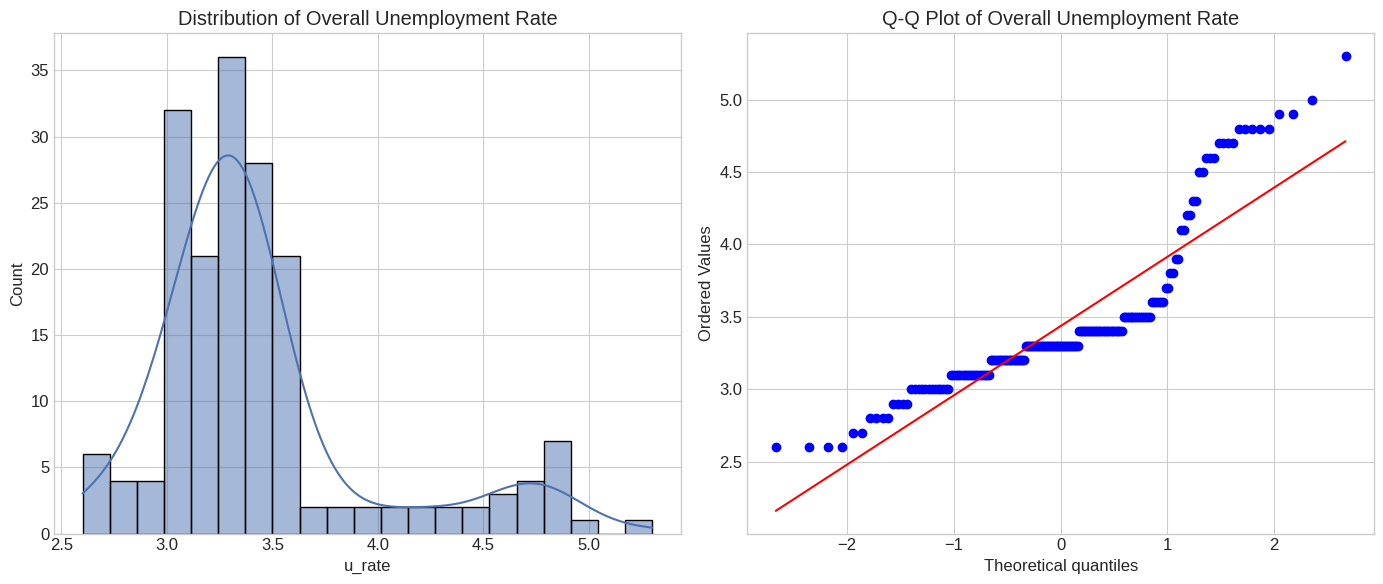


------------------------------------------------------------
Augmented Dickey-Fuller Test for Stationarity: Overall Unemployment Rate
------------------------------------------------------------
ADF Statistic: -2.3118
P-value: 0.1682
Critical Values:
	1%: -3.4670
	5%: -2.8776
	10%: -2.5754
Conclusion: Fail to reject the null hypothesis. The series is non-stationary.


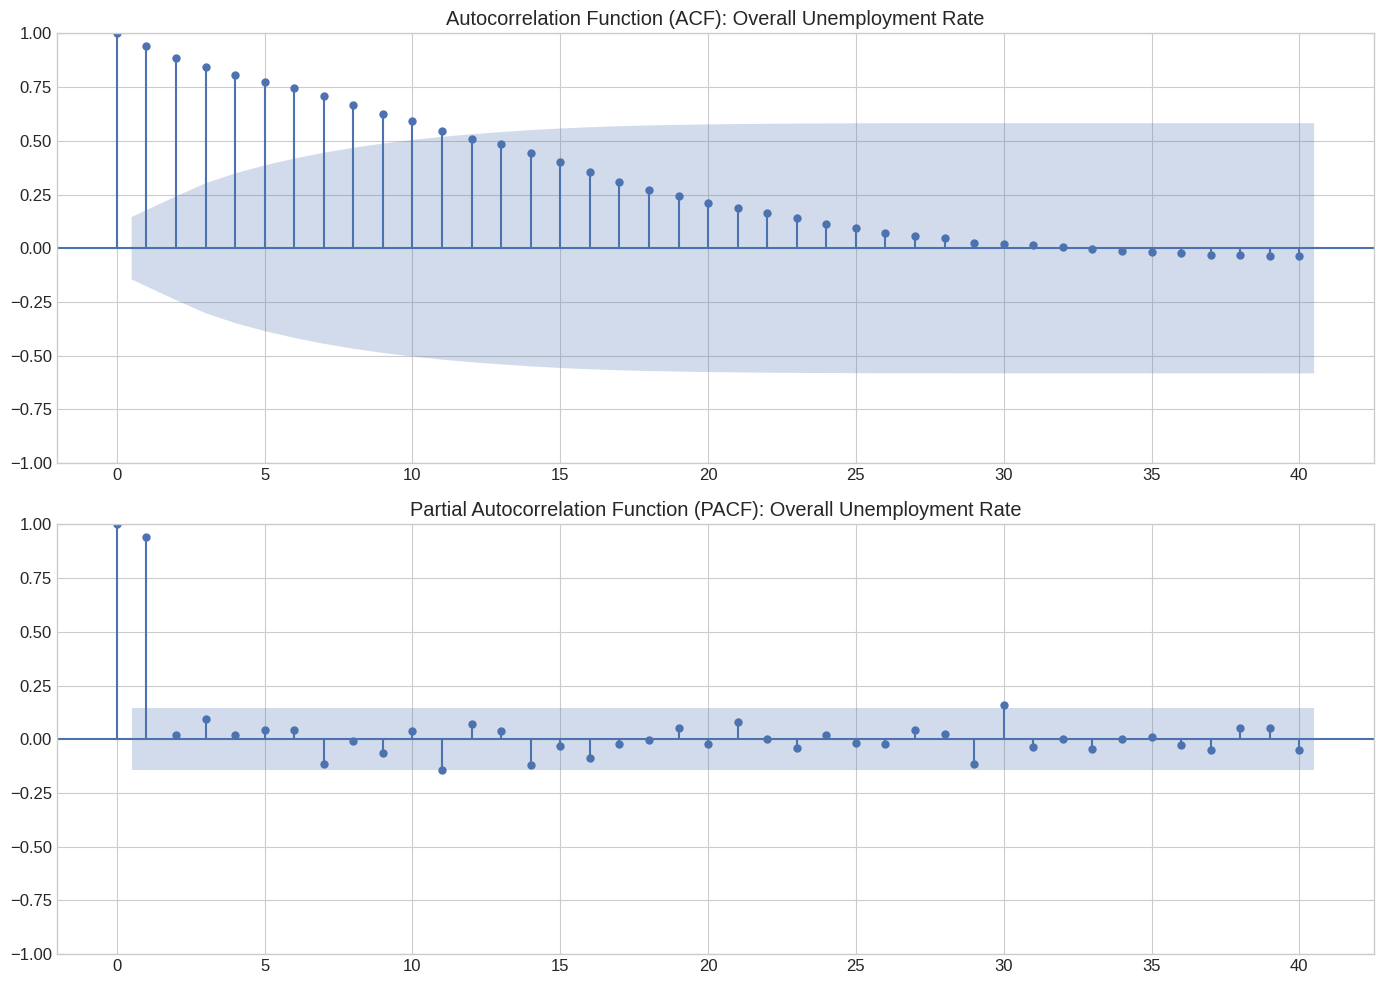


------------------------------------------------------------
Jarque-Bera Test for Normality: Youth Unemployment Rate (15-24)
------------------------------------------------------------
JB Statistic: 6.6650
P-value: 0.0357
Skewness: 0.4926
Kurtosis: 2.3045
Conclusion: Reject the null hypothesis. The data is NOT normally distributed.


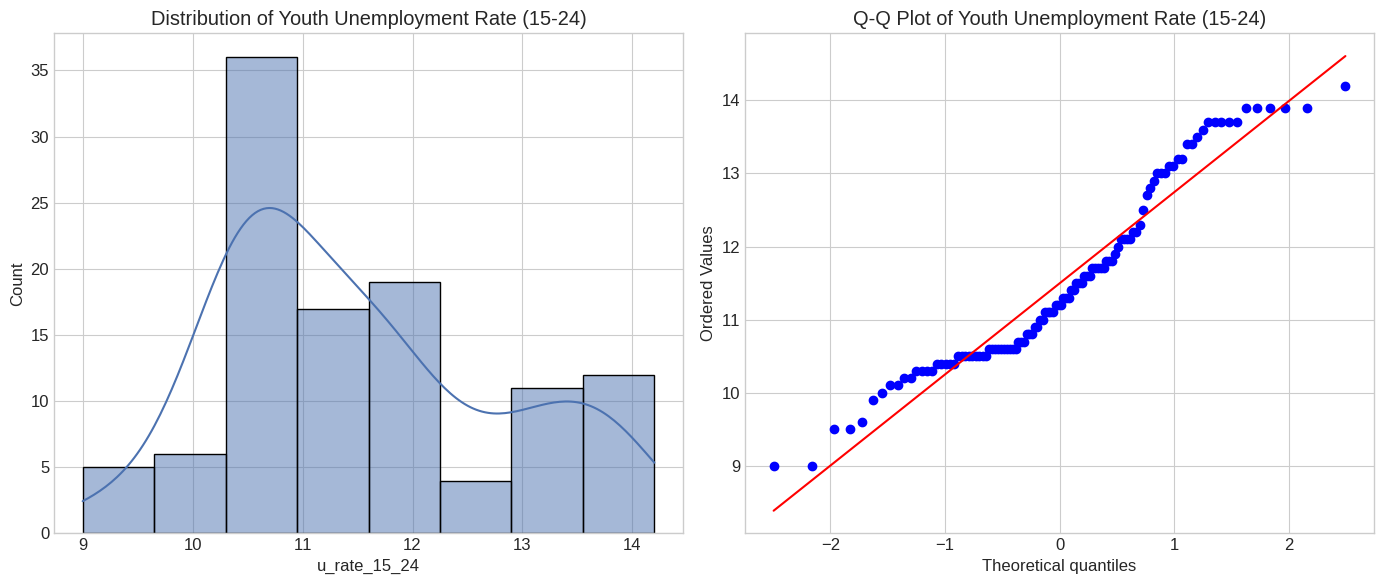


------------------------------------------------------------
Augmented Dickey-Fuller Test for Stationarity: Youth Unemployment Rate (15-24)
------------------------------------------------------------
ADF Statistic: -1.6565
P-value: 0.4536
Critical Values:
	1%: -3.4930
	5%: -2.8890
	10%: -2.5814
Conclusion: Fail to reject the null hypothesis. The series is non-stationary.


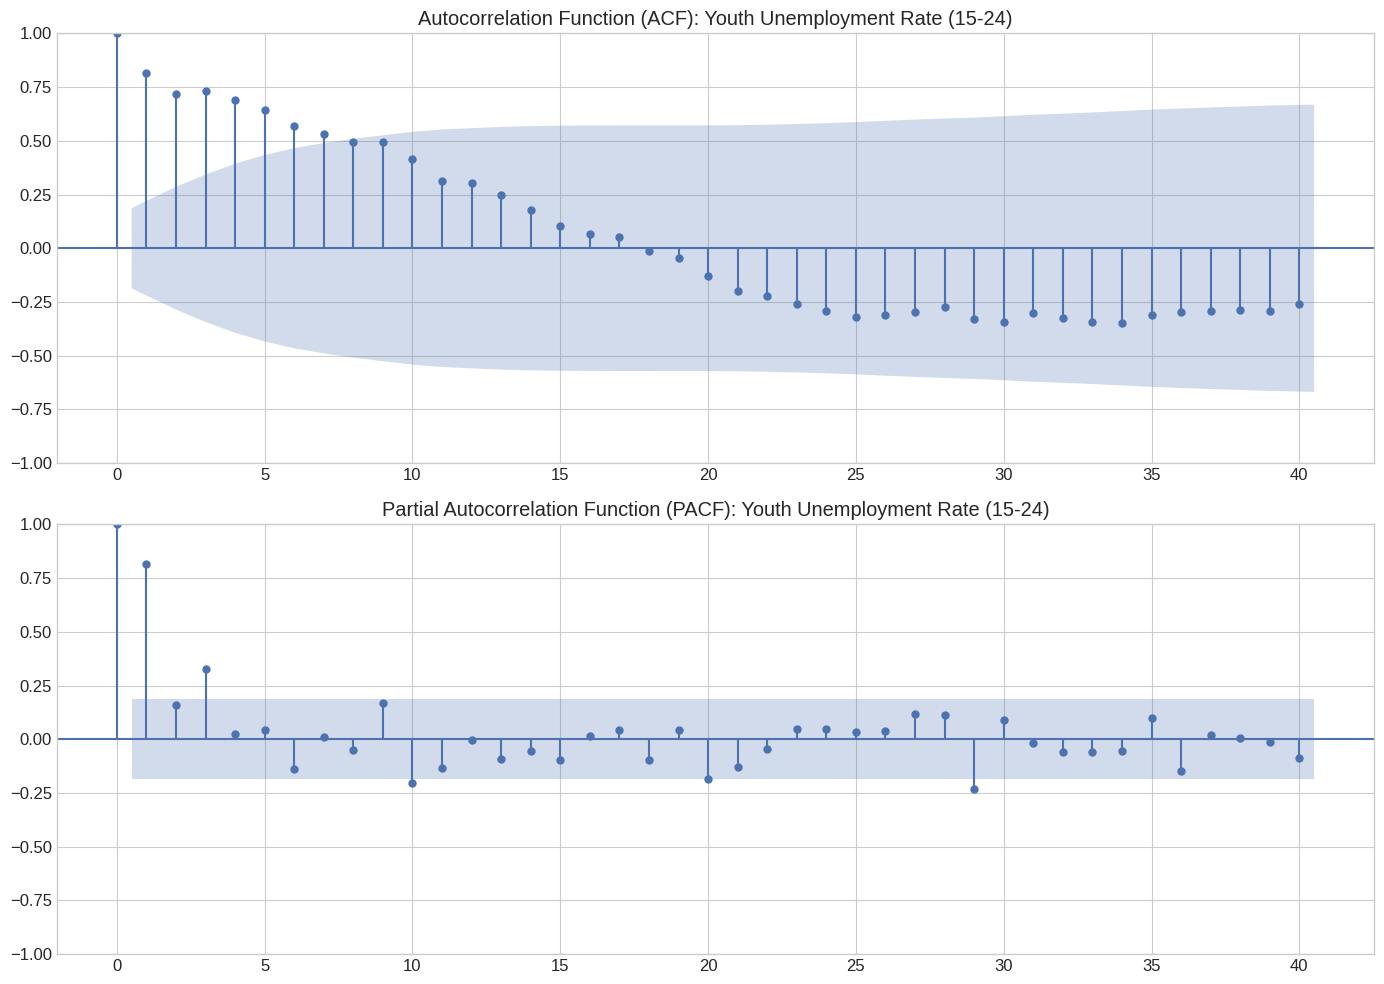


------------------------------------------------------------
Jarque-Bera Test for Normality: Seasonally Adjusted Unemployment Rate
------------------------------------------------------------
JB Statistic: 105.5166
P-value: 0.0000
Skewness: 1.5730
Kurtosis: 5.0042
Conclusion: Reject the null hypothesis. The data is NOT normally distributed.


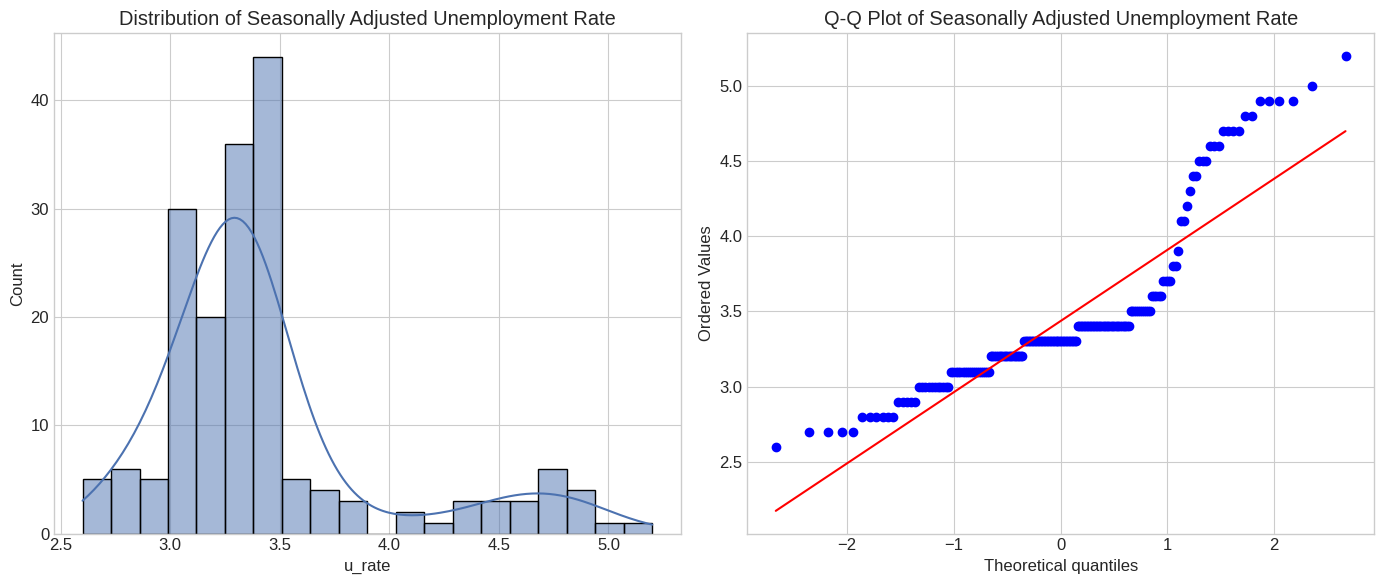


------------------------------------------------------------
Augmented Dickey-Fuller Test for Stationarity: Seasonally Adjusted Unemployment Rate
------------------------------------------------------------
ADF Statistic: -2.2227
P-value: 0.1981
Critical Values:
	1%: -3.4699
	5%: -2.8789
	10%: -2.5760
Conclusion: Fail to reject the null hypothesis. The series is non-stationary.


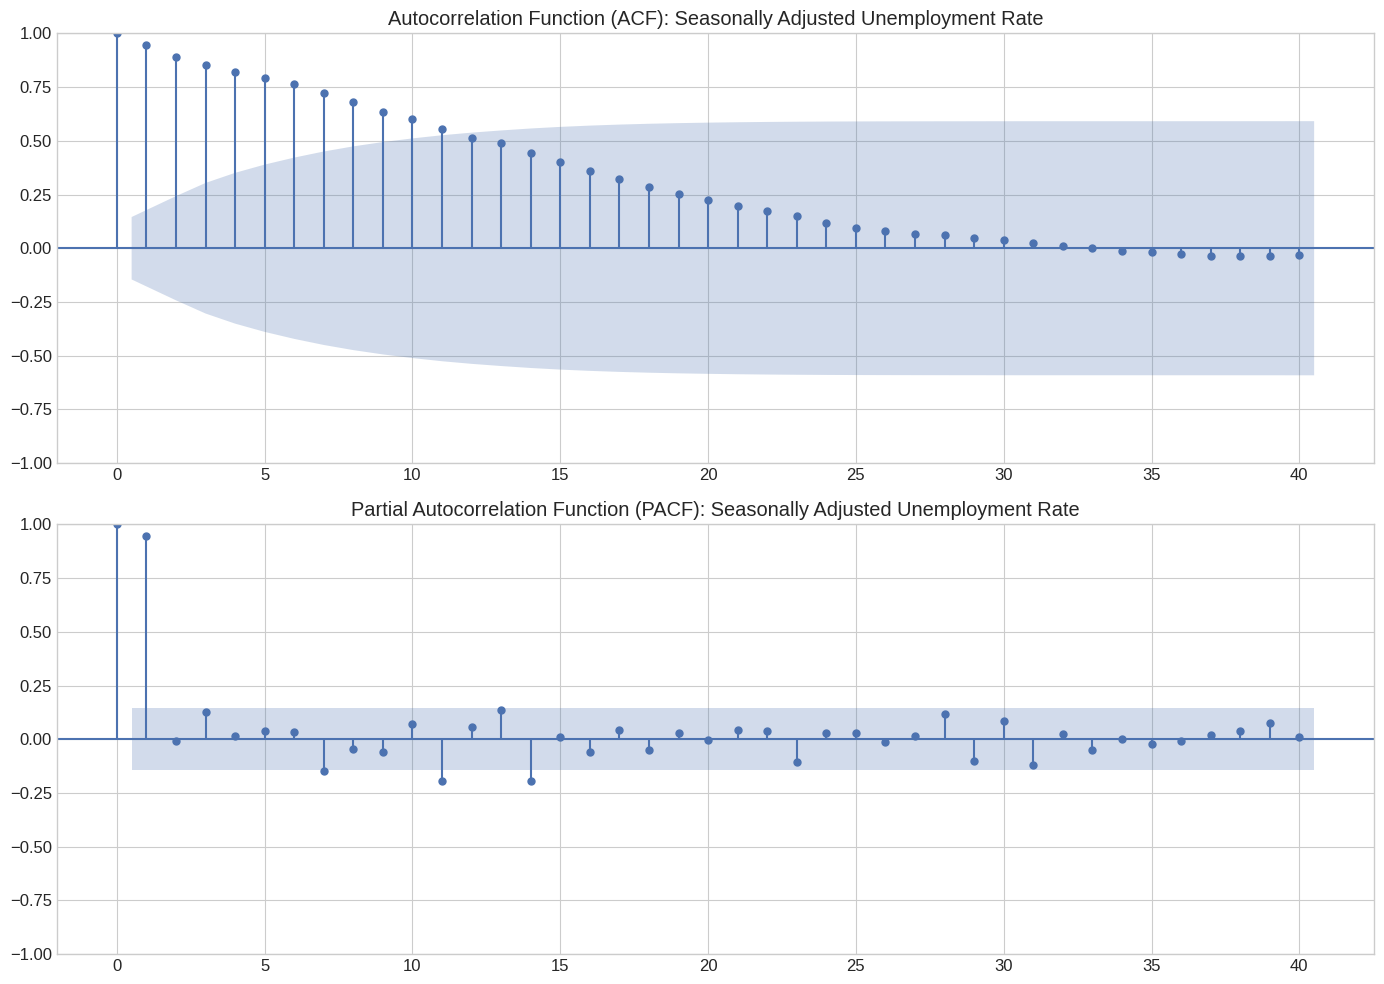

In [ ]:

from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def jarque_bera_test(series, title):
    """Perform Jarque-Bera test for normality"""
    jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(series.dropna())

    print(f"\n{'-'*60}")
    print(f"Jarque-Bera Test for Normality: {title}")
    print(f"{'-'*60}")
    print(f"JB Statistic: {jb_stat:.4f}")
    print(f"P-value: {jb_pvalue:.4f}")
    print(f"Skewness: {skew:.4f}")
    print(f"Kurtosis: {kurtosis:.4f}")

    if jb_pvalue < 0.05:
        print("Conclusion: Reject the null hypothesis. The data is NOT normally distributed.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. The data appears to be normally distributed.")

    # Visualize distribution
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(series.dropna(), kde=True)
    plt.title(f"Distribution of {title}")

    plt.subplot(1, 2, 2)
    stats.probplot(series.dropna(), plot=plt)
    plt.title(f"Q-Q Plot of {title}")

    plt.tight_layout()
    plt.show()

def adf_test(series, title):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(series.dropna())

    print(f"\n{'-'*60}")
    print(f"Augmented Dickey-Fuller Test for Stationarity: {title}")
    print(f"{'-'*60}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"P-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.4f}")

    if result[1] < 0.05:
        print("Conclusion: Reject the null hypothesis. The series is stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. The series is non-stationary.")

def plot_acf_pacf(series, title, lags=40):
    """Plot ACF and PACF for time series"""
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # ACF
    plot_acf(series.dropna(), lags=lags, ax=axes[0], title=f"Autocorrelation Function (ACF): {title}")

    # PACF
    plot_pacf(series.dropna(), lags=lags, ax=axes[1], title=f"Partial Autocorrelation Function (PACF): {title}")

    plt.tight_layout()
    plt.show()

# Import scipy stats
import scipy.stats as stats

# Perform tests on key series
# Overall unemployment rate
jarque_bera_test(lfs_month_ts['u_rate'], 'Overall Unemployment Rate')
adf_test(lfs_month_ts['u_rate'], 'Overall Unemployment Rate')
plot_acf_pacf(lfs_month_ts['u_rate'], 'Overall Unemployment Rate')

# Youth unemployment rate
jarque_bera_test(lfs_month_youth_ts['u_rate_15_24'], 'Youth Unemployment Rate (15-24)')
adf_test(lfs_month_youth_ts['u_rate_15_24'], 'Youth Unemployment Rate (15-24)')
plot_acf_pacf(lfs_month_youth_ts['u_rate_15_24'], 'Youth Unemployment Rate (15-24)')

# Seasonally adjusted unemployment rate
jarque_bera_test(lfs_month_sa_ts['u_rate'], 'Seasonally Adjusted Unemployment Rate')
adf_test(lfs_month_sa_ts['u_rate'], 'Seasonally Adjusted Unemployment Rate')
plot_acf_pacf(lfs_month_sa_ts['u_rate'], 'Seasonally Adjusted Unemployment Rate')

##  Data Transformation Exploration

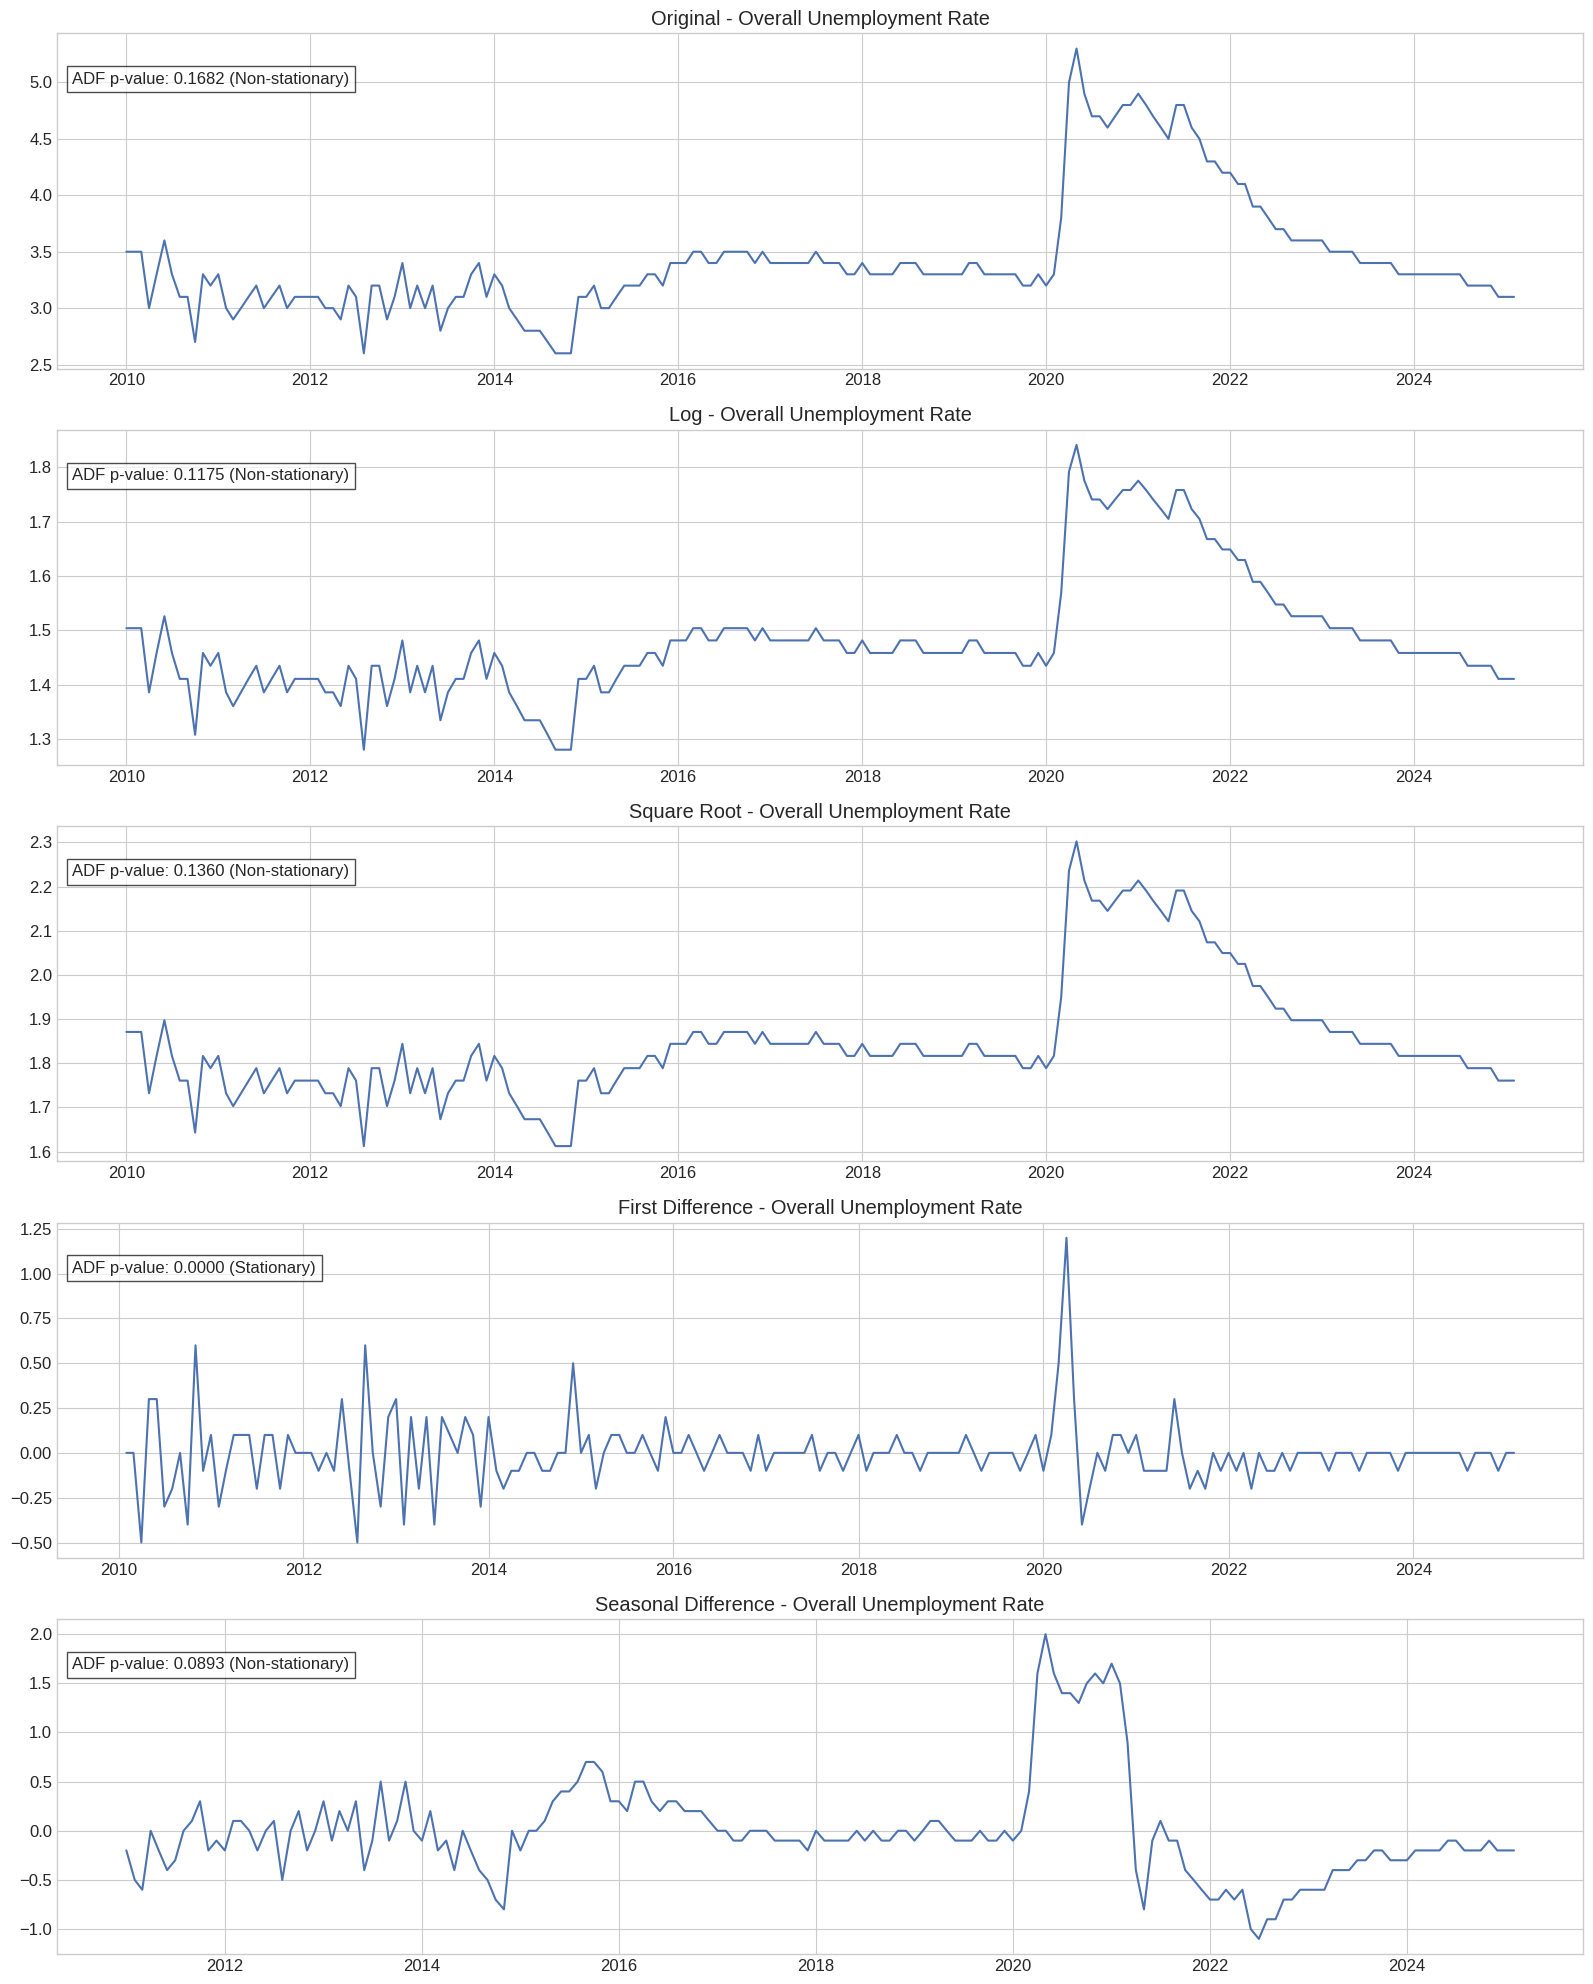

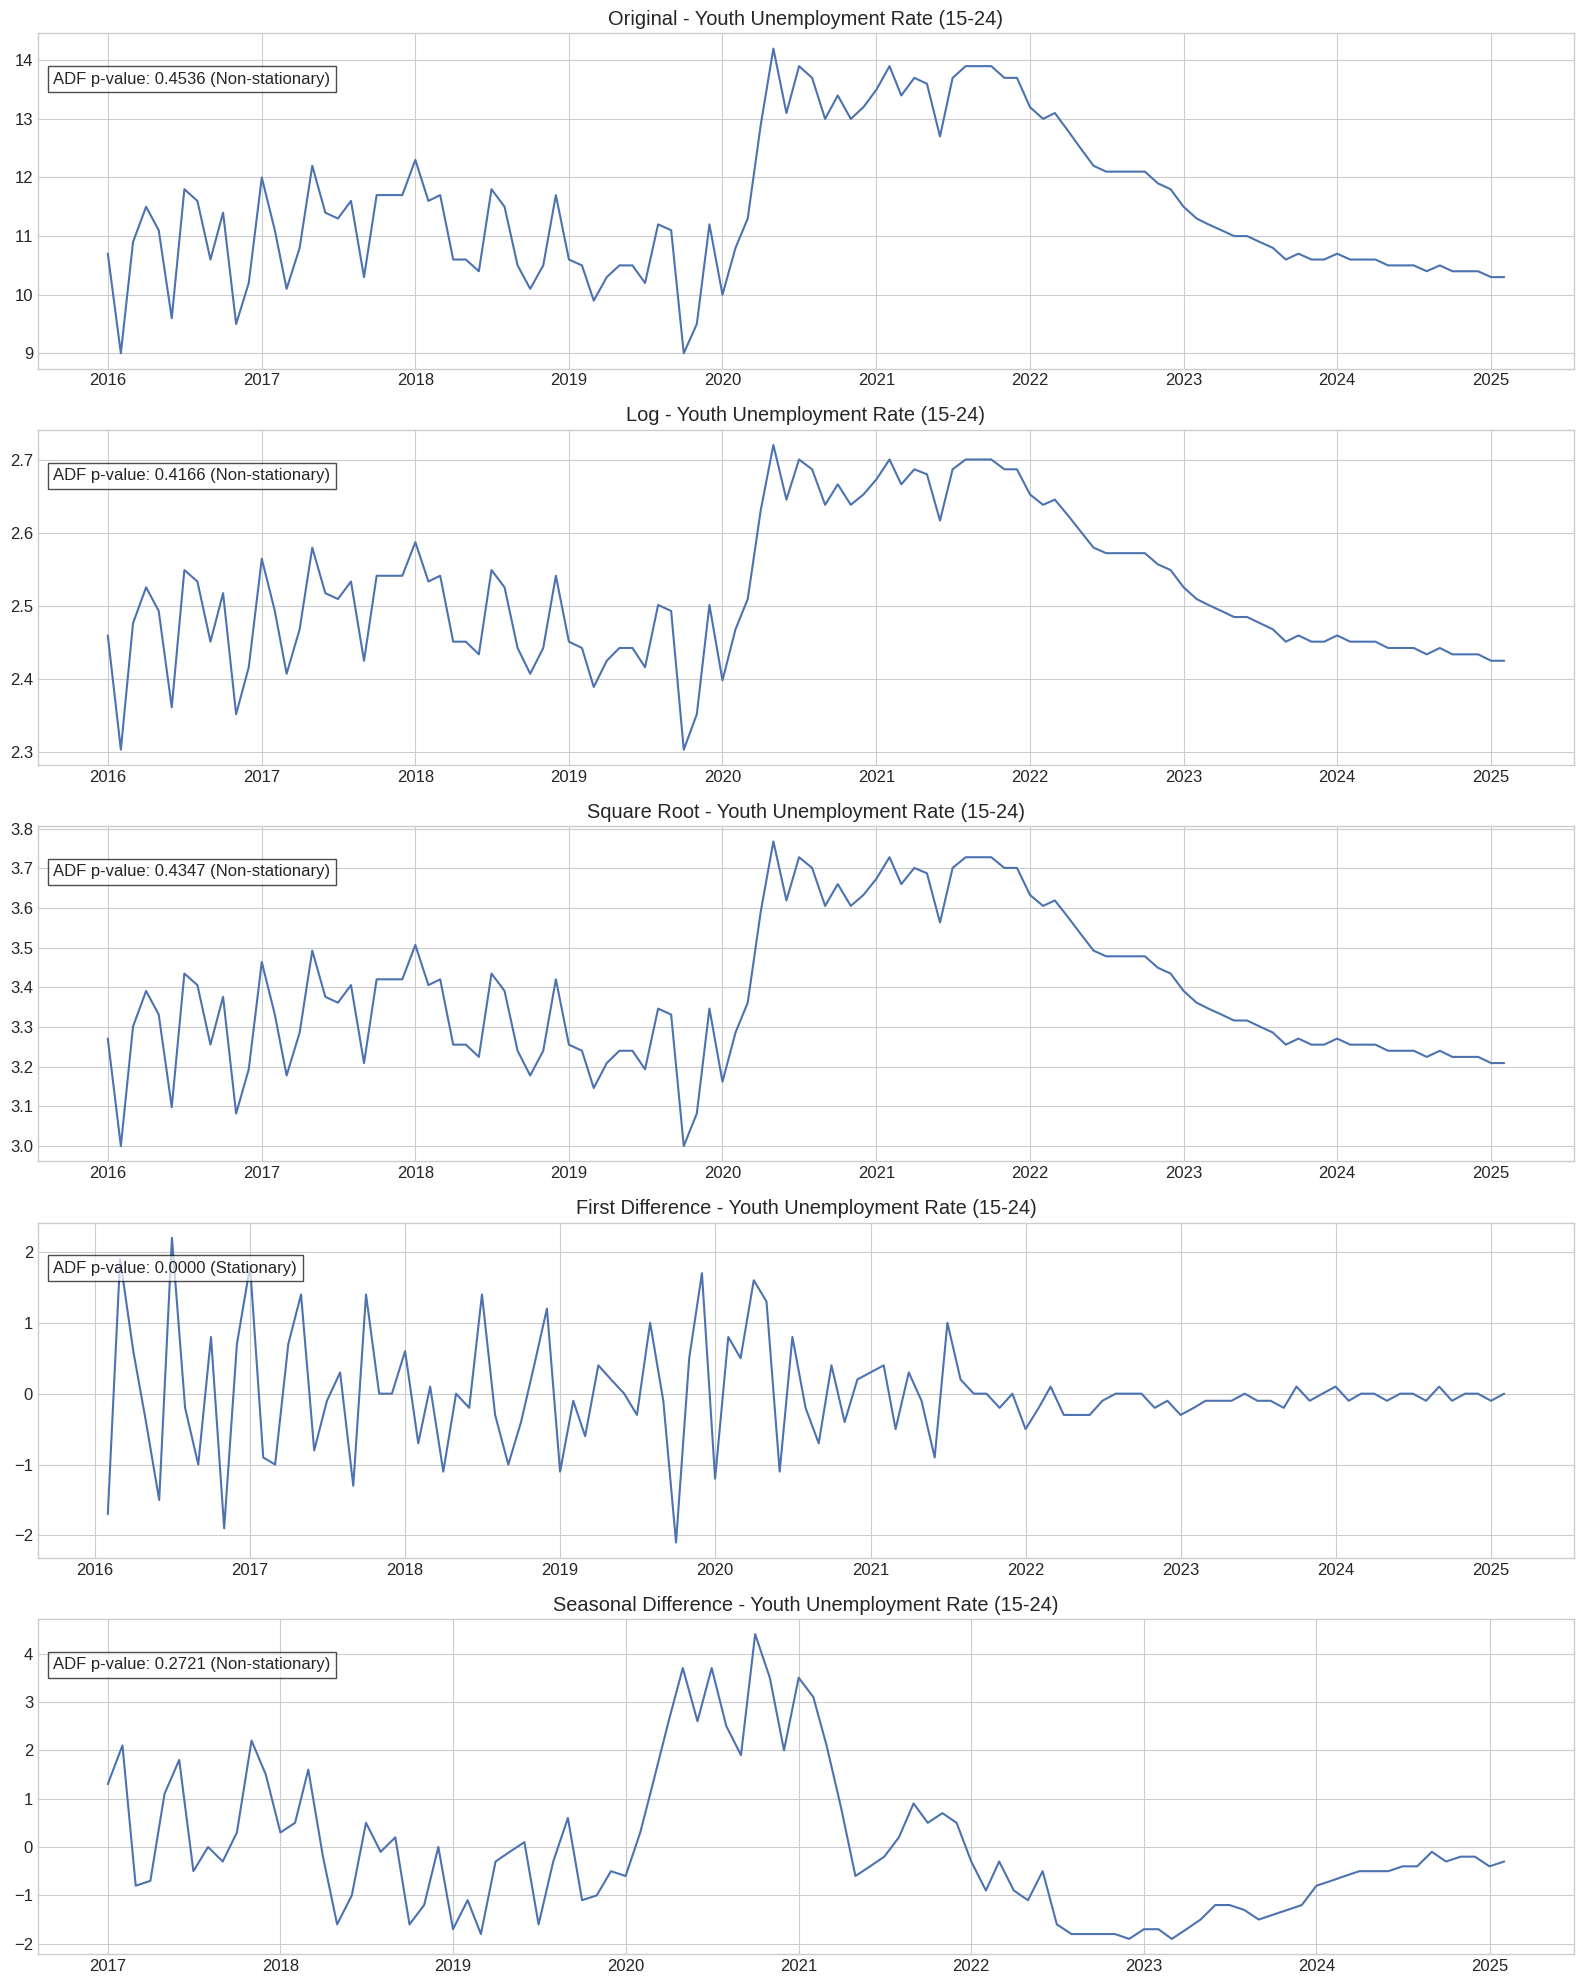

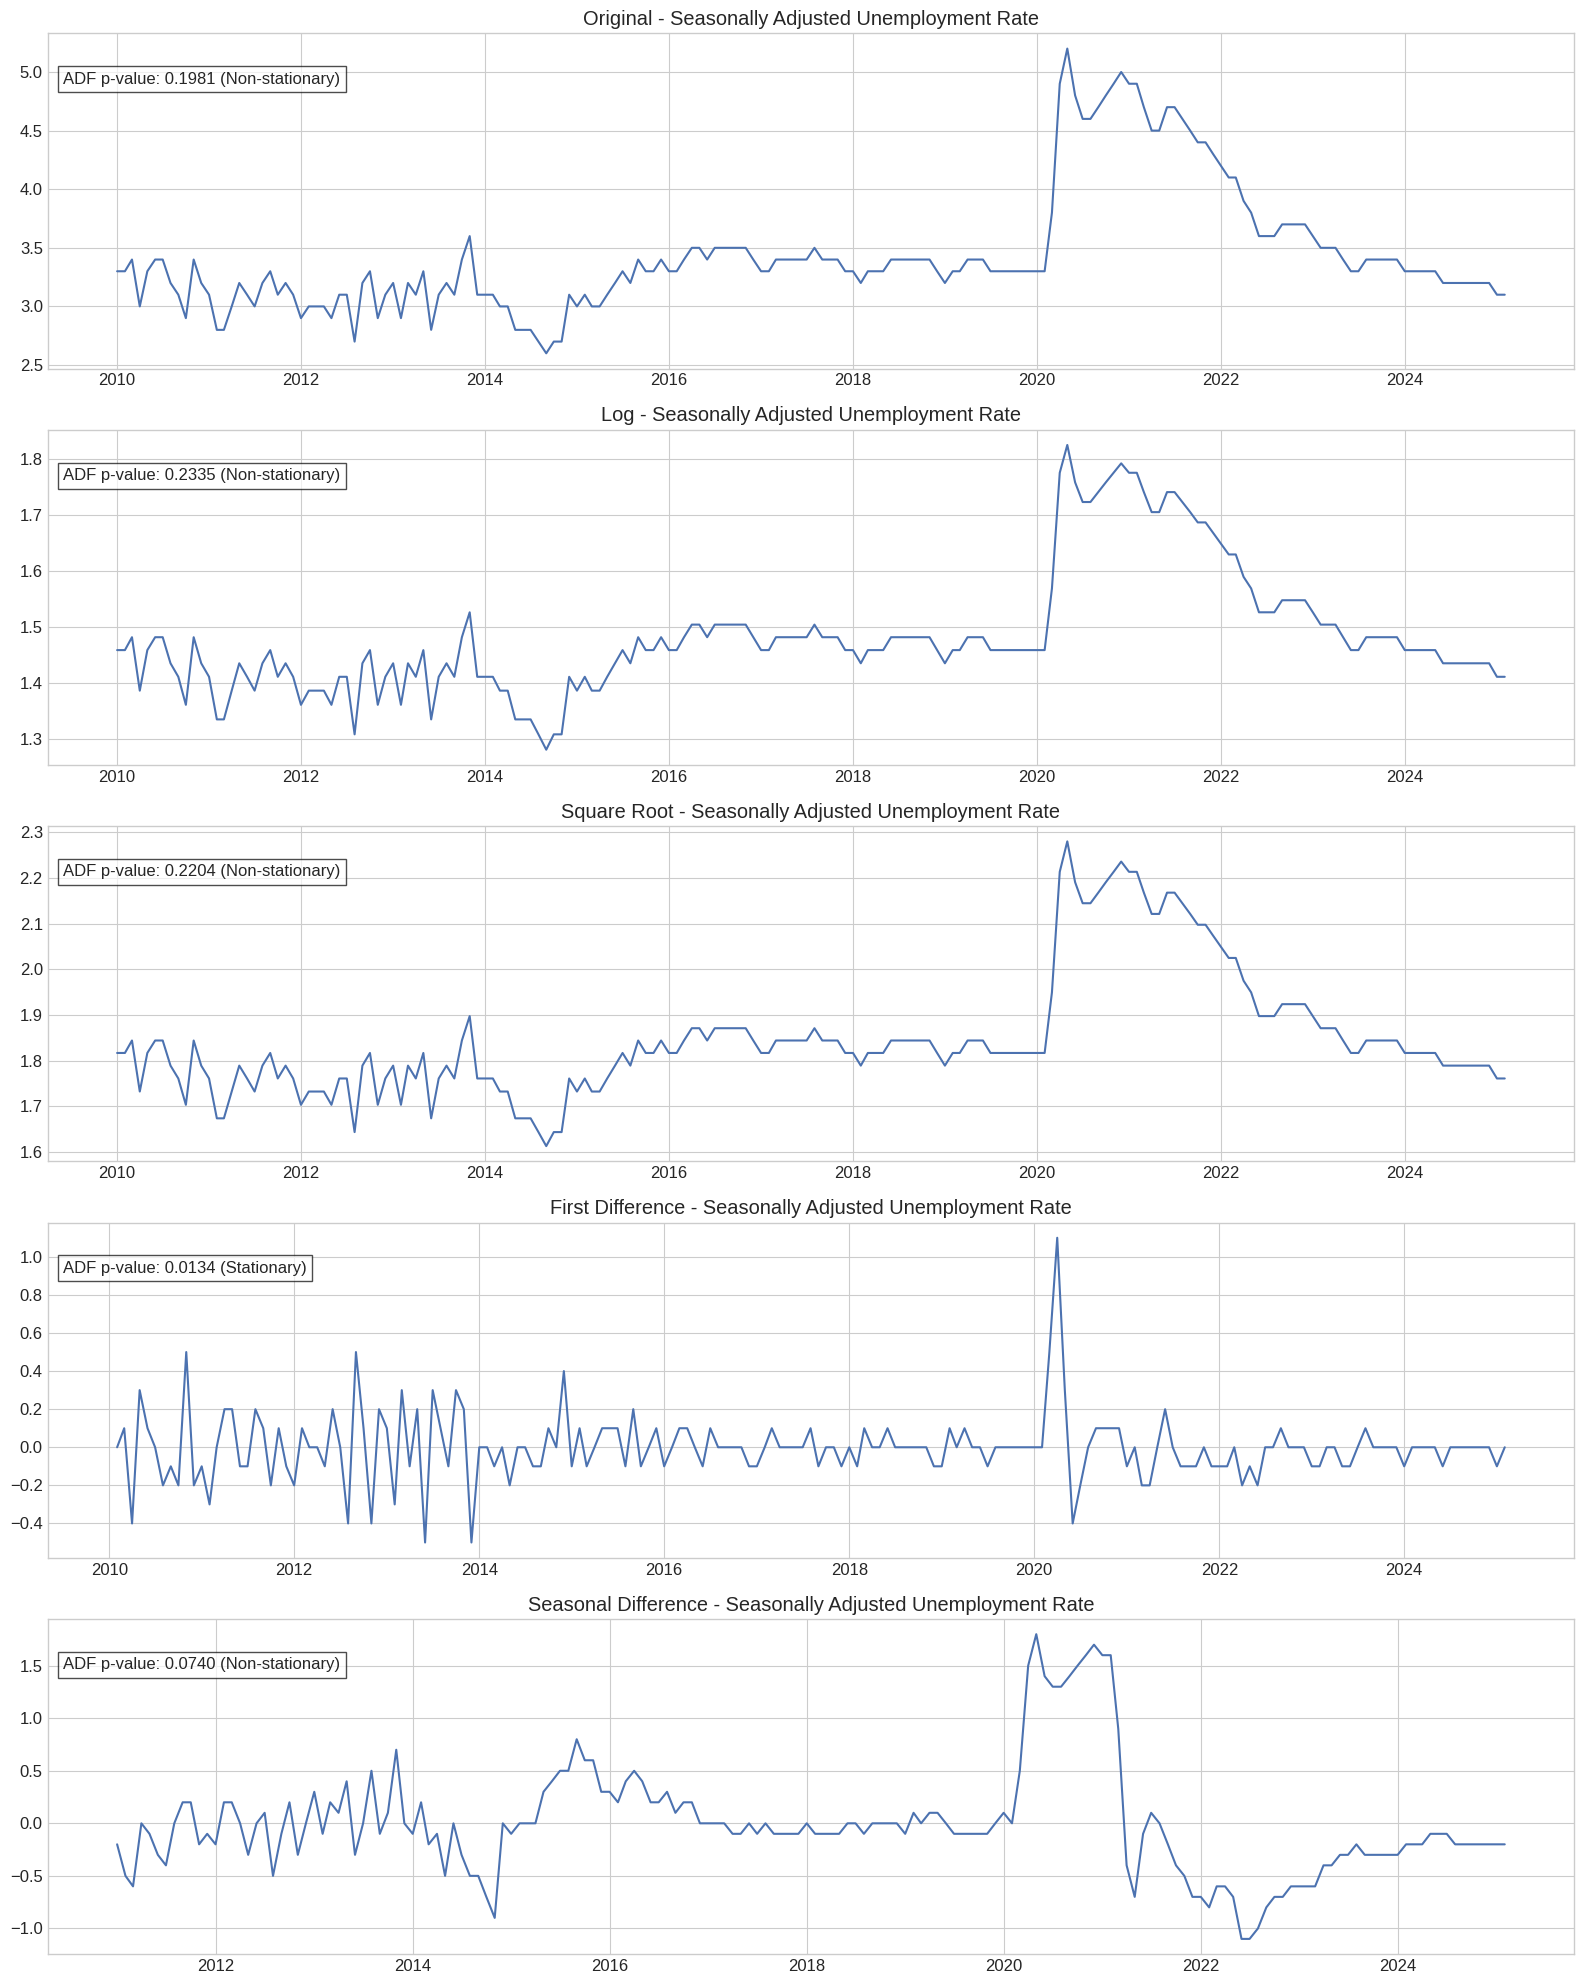

In [ ]:

import numpy as np

def explore_transformations(series, title):
    """Explore various transformations for time series data"""
    # Create transformations
    transformations = {
        'Original': series,
        'Log': np.log1p(series) if (series > 0).all() else np.log1p(series - series.min() + 0.01),
        'Square Root': np.sqrt(series) if (series >= 0).all() else np.sqrt(series - series.min() + 0.01),
        'First Difference': series.diff().dropna(),
        'Seasonal Difference': series.diff(12).dropna()
    }

    # Create subplots
    fig, axes = plt.subplots(len(transformations), 1, figsize=(16, 4*len(transformations)))

    # Plot each transformation
    for i, (name, data) in enumerate(transformations.items()):
        axes[i].plot(data)
        axes[i].set_title(f"{name} - {title}")
        axes[i].grid(True)

        # Add stationarity info
        try:
            result = adfuller(data.dropna())
            p_value = result[1]
            status = "Stationary" if p_value < 0.05 else "Non-stationary"
            axes[i].text(0.01, 0.85, f"ADF p-value: {p_value:.4f} ({status})",
                        transform=axes[i].transAxes, bbox=dict(facecolor='white', alpha=0.7))
        except:
            pass

    plt.tight_layout()
    plt.show()

    return transformations

# Exploring transformations for key series
# Overall unemployment rate
transformations_overall = explore_transformations(lfs_month_ts['u_rate'], 'Overall Unemployment Rate')

# Youth unemployment rate
transformations_youth = explore_transformations(lfs_month_youth_ts['u_rate_15_24'], 'Youth Unemployment Rate (15-24)')

# Seasonally adjusted unemployment rate
transformations_sa = explore_transformations(lfs_month_sa_ts['u_rate'], 'Seasonally Adjusted Unemployment Rate')

## Multivariate Analysis

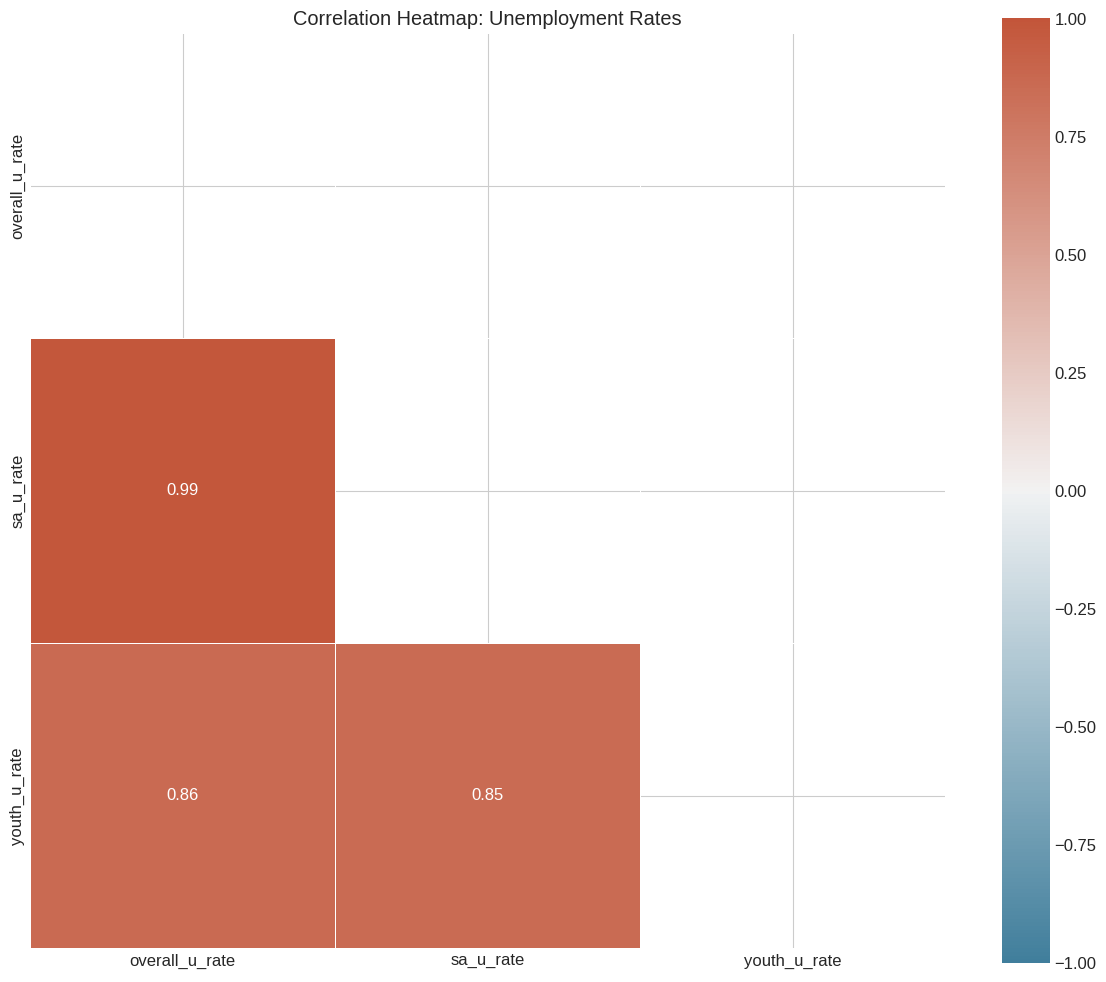

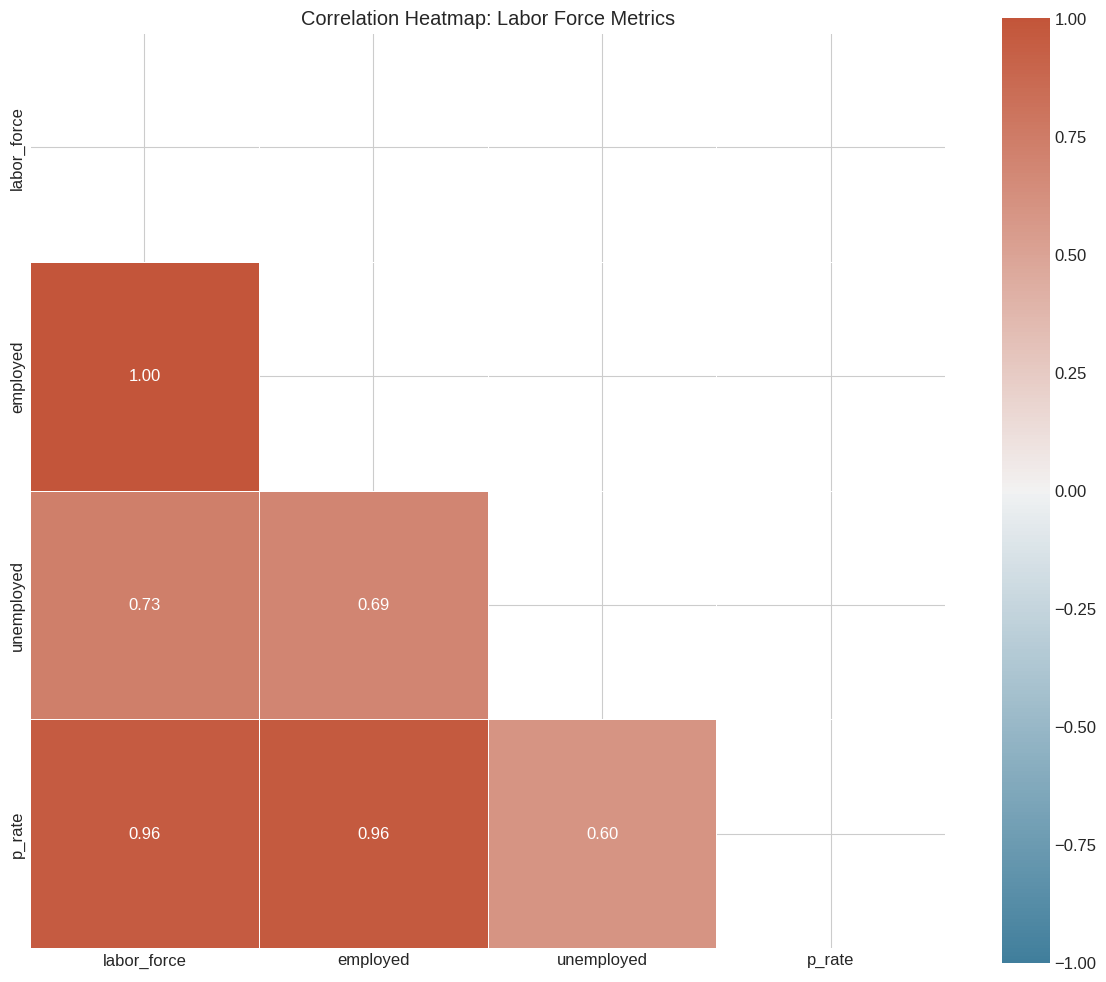


------------------------------------------------------------
Granger Causality Test Results
------------------------------------------------------------
sa_u_rate Granger-causes overall_u_rate with p-value: 0.0311
youth_u_rate Granger-causes overall_u_rate with p-value: 0.0000
overall_u_rate Granger-causes sa_u_rate with p-value: 0.0004
youth_u_rate Granger-causes sa_u_rate with p-value: 0.0000
sa_u_rate Granger-causes youth_u_rate with p-value: 0.0346

------------------------------------------------------------
Granger Causality Test Results
------------------------------------------------------------
employed Granger-causes labor_force with p-value: 0.0008
p_rate Granger-causes labor_force with p-value: 0.0000
p_rate Granger-causes employed with p-value: 0.0000
employed Granger-causes unemployed with p-value: 0.0008
p_rate Granger-causes unemployed with p-value: 0.0279
labor_force Granger-causes p_rate with p-value: 0.0000
employed Granger-causes p_rate with p-value: 0.0000
unemplo

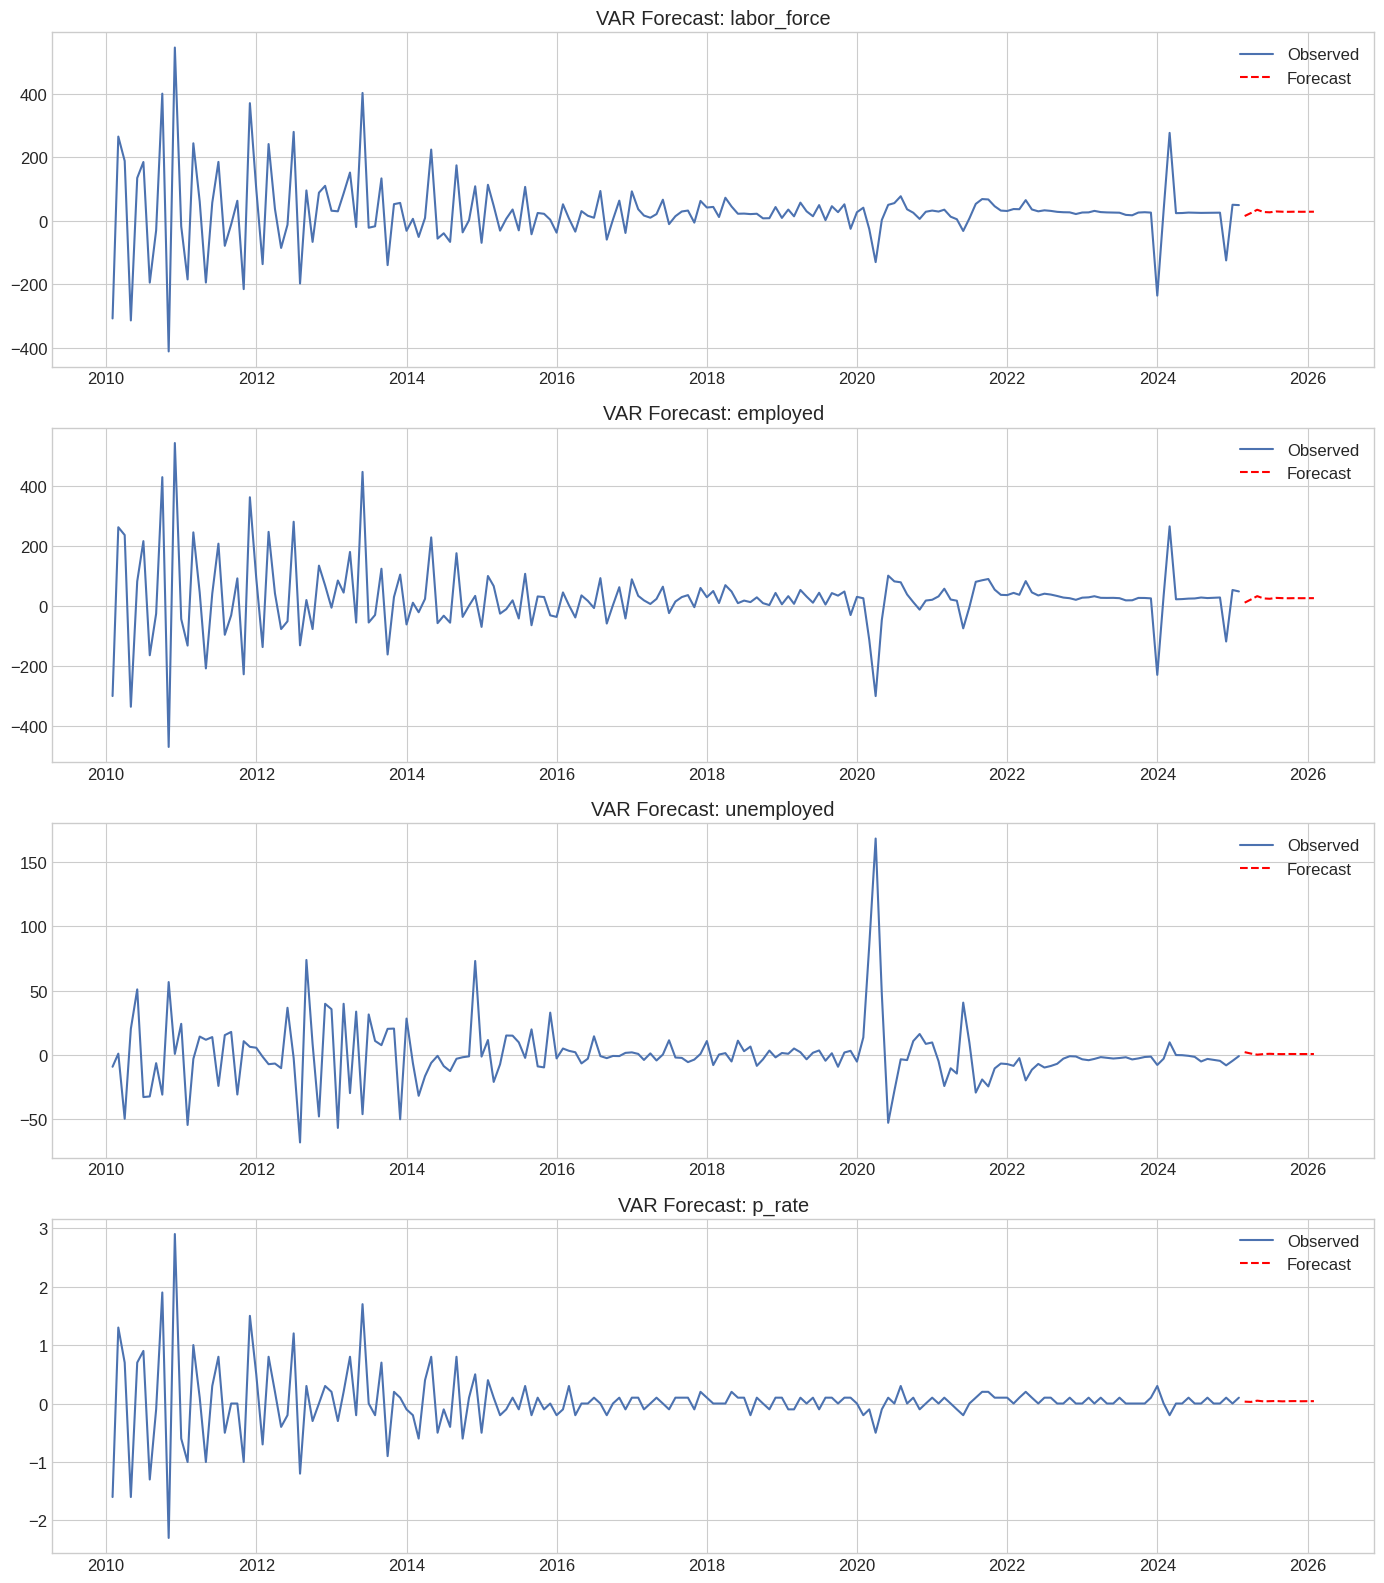

In [ ]:

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

def correlation_heatmap(df, title):
    """Create correlation heatmap for multivariate analysis"""
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5)

    plt.title(f'Correlation Heatmap: {title}')
    plt.tight_layout()
    plt.show()

    return corr_matrix

def granger_causality(df, max_lag=12, verbose=False):
    """Test for Granger causality between variables"""
    variables = df.columns.tolist()
    results = {}

    print(f"\n{'-'*60}")
    print("Granger Causality Test Results")
    print(f"{'-'*60}")

    for i, v1 in enumerate(variables):
        results[v1] = {}
        for j, v2 in enumerate(variables):
            if i != j:  # Skip self-causality
                test_df = pd.concat([df[v2], df[v1]], axis=1).dropna()
                if len(test_df) > max_lag + 2:  # Ensure enough data for testing
                    try:
                        test_result = grangercausalitytests(test_df, maxlag=max_lag, verbose=verbose)
                        min_p_value = min([test_result[i+1][0]['ssr_ftest'][1] for i in range(max_lag)])
                        results[v1][v2] = min_p_value

                        # Print result if significant
                        if min_p_value < 0.05:
                            print(f"{v2} Granger-causes {v1} with p-value: {min_p_value:.4f}")
                    except:
                        results[v1][v2] = None
                else:
                    results[v1][v2] = None

    return results

def var_analysis(df, max_lags=12):
    """Perform Vector Autoregression analysis"""
    # confirm data is stationary if not use first differencing
    df_var = df.copy()
    adf_results = {}

    for col in df_var.columns:
        adf_result = adfuller(df_var[col].dropna())
        adf_results[col] = adf_result[1] < 0.05  # True if stationary

    # Apply first differencing to non-stationary series
    for col in df_var.columns:
        if not adf_results[col]:
            print(f"Applying first differencing to {col} as it is non-stationary")
            df_var[col] = df_var[col].diff().dropna()

    # Drop NaN values after differencing
    df_var = df_var.dropna()

    print(f"\n{'-'*60}")
    print("Vector Autoregression Analysis")
    print(f"{'-'*60}")

    # Determine optimal lag order
    try:
        model = VAR(df_var)
        results = model.select_order(maxlags=max_lags)
        print("\nOptimal lag selection:")
        print(results.summary())

        # Fit VAR model with optimal lag order
        lag_order = results.selected_orders['aic']
        print(f"\nFitting VAR model with lag order {lag_order}")
        model_fitted = model.fit(lag_order)
        print(model_fitted.summary())

        # Forecast
        lag_order = min(lag_order, 4)  # Limit for visualization
        forecast = model_fitted.forecast(df_var.values[-lag_order:], 12)
        forecast_index = pd.date_range(start=df_var.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
        forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=df_var.columns)

        # Plot forecasts
        fig, axes = plt.subplots(len(df_var.columns), 1, figsize=(14, 4*len(df_var.columns)))
        if len(df_var.columns) == 1:
            axes = [axes]

        for i, col in enumerate(df_var.columns):
            axes[i].plot(df_var.index, df_var[col], label='Observed')
            axes[i].plot(forecast_index, forecast_df[col], 'r--', label='Forecast')
            axes[i].set_title(f'VAR Forecast: {col}')
            axes[i].legend()
            axes[i].grid(True)

        plt.tight_layout()
        plt.show()

        return model_fitted, forecast_df
    except Exception as e:
        print(f"VAR analysis failed: {str(e)}")
        return None, None

# Prepare data for multivariate analysis
multi_u_rates = pd.DataFrame({
    'overall_u_rate': lfs_month_ts['u_rate'],
    'sa_u_rate': lfs_month_sa_ts['u_rate'].reindex(lfs_month_ts.index),
    'youth_u_rate': lfs_month_youth_ts['u_rate_15_24'].reindex(lfs_month_ts.index)
}).dropna()

multi_labor_force = pd.DataFrame({
    'labor_force': lfs_month_ts['lf'],
    'employed': lfs_month_ts['lf_employed'],
    'unemployed': lfs_month_ts['lf_unemployed'],
    'p_rate': lfs_month_ts['p_rate']
}).dropna()

# Perform multivariate analyses
corr_u_rates = correlation_heatmap(multi_u_rates, 'Unemployment Rates')
corr_labor_force = correlation_heatmap(multi_labor_force, 'Labor Force Metrics')

# Granger causality tests
granger_u_rates = granger_causality(multi_u_rates)
granger_labor_force = granger_causality(multi_labor_force)

# Vector autoregression analysis
var_model_u_rates, forecast_u_rates = var_analysis(multi_u_rates)
var_model_labor_force, forecast_labor_force = var_analysis(multi_labor_force)

## Detailed Statistical Tests



####################################################################################################
DETAILED STATISTICAL ANALYSIS FOR: Overall Unemployment
####################################################################################################

JARQUE-BERA TEST FOR NORMALITY
H0: Data is normally distributed
H1: Data is not normally distributed
--------------------------------------------------------------------------------
Variable                       JB Statistic    p-value         Skewness        Kurtosis        Conclusion          
--------------------------------------------------------------------------------
u_rate                         104.8113        0.0000          1.5489          5.0554          Non-normal          


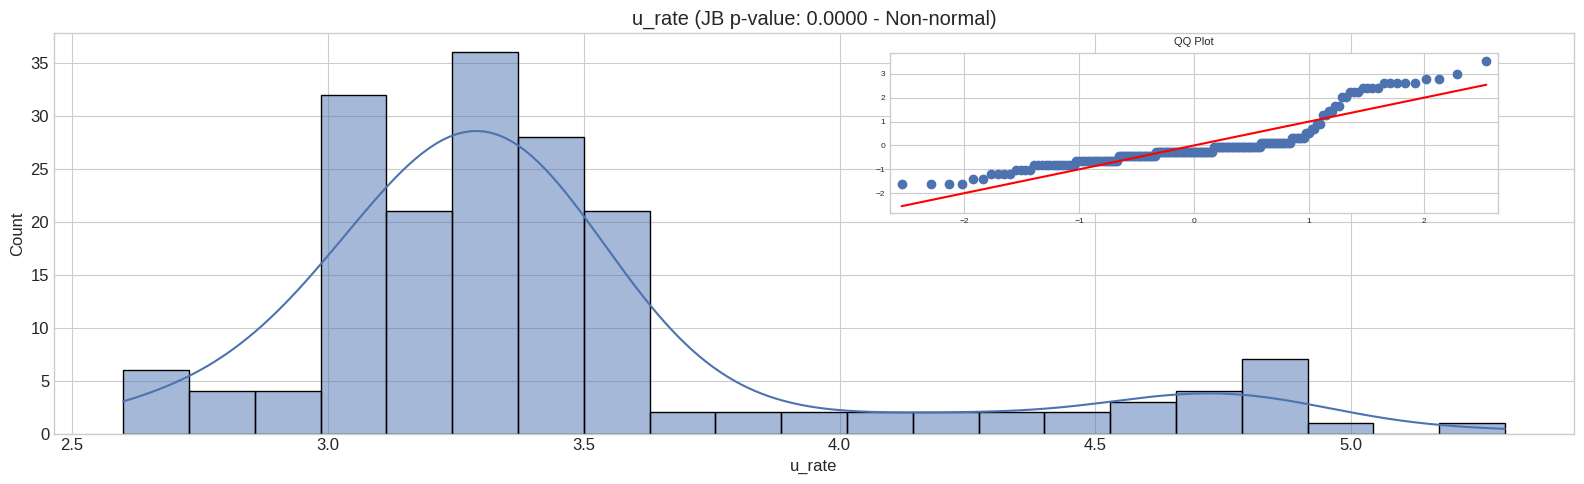


AUGMENTED DICKEY-FULLER TEST FOR STATIONARITY
H0: The time series has a unit root (non-stationary)
H1: The time series does not have a unit root (stationary)
--------------------------------------------------------------------------------
Variable                       ADF Statistic   p-value         Critical Value (1%)  Conclusion     
--------------------------------------------------------------------------------
u_rate                         -2.3118         0.1682          -3.4670              Non-stationary 


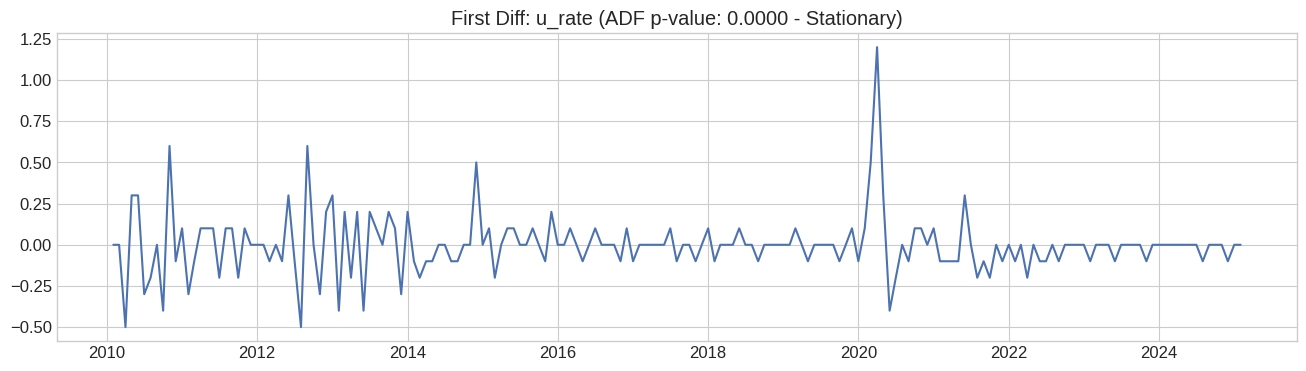

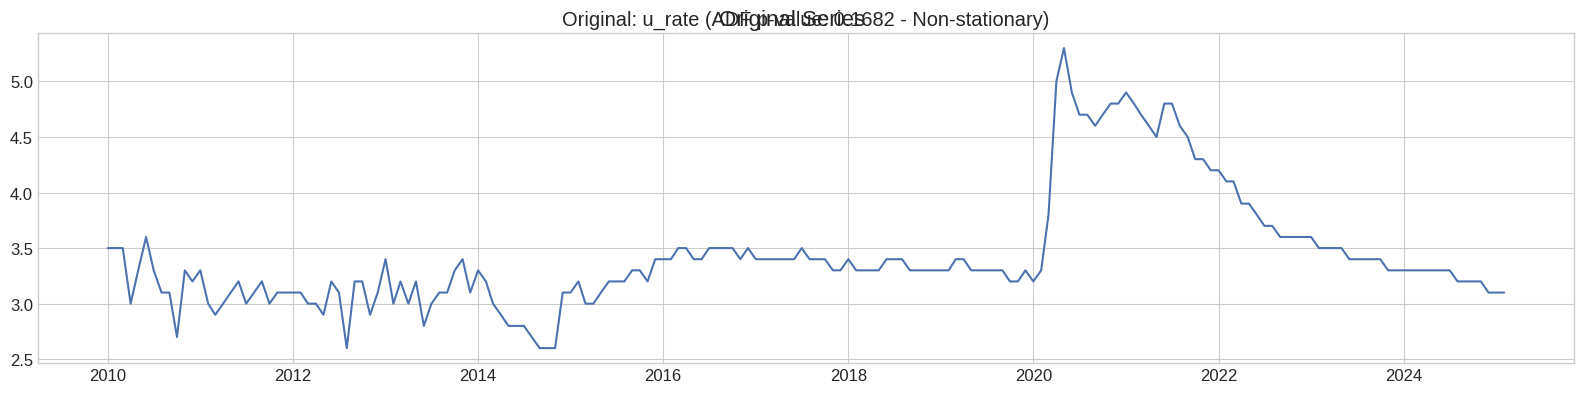

<Figure size 1400x800 with 0 Axes>


ACF AND PACF ANALYSIS

------------------------------------------------------------
Variable: u_rate
------------------------------------------------------------


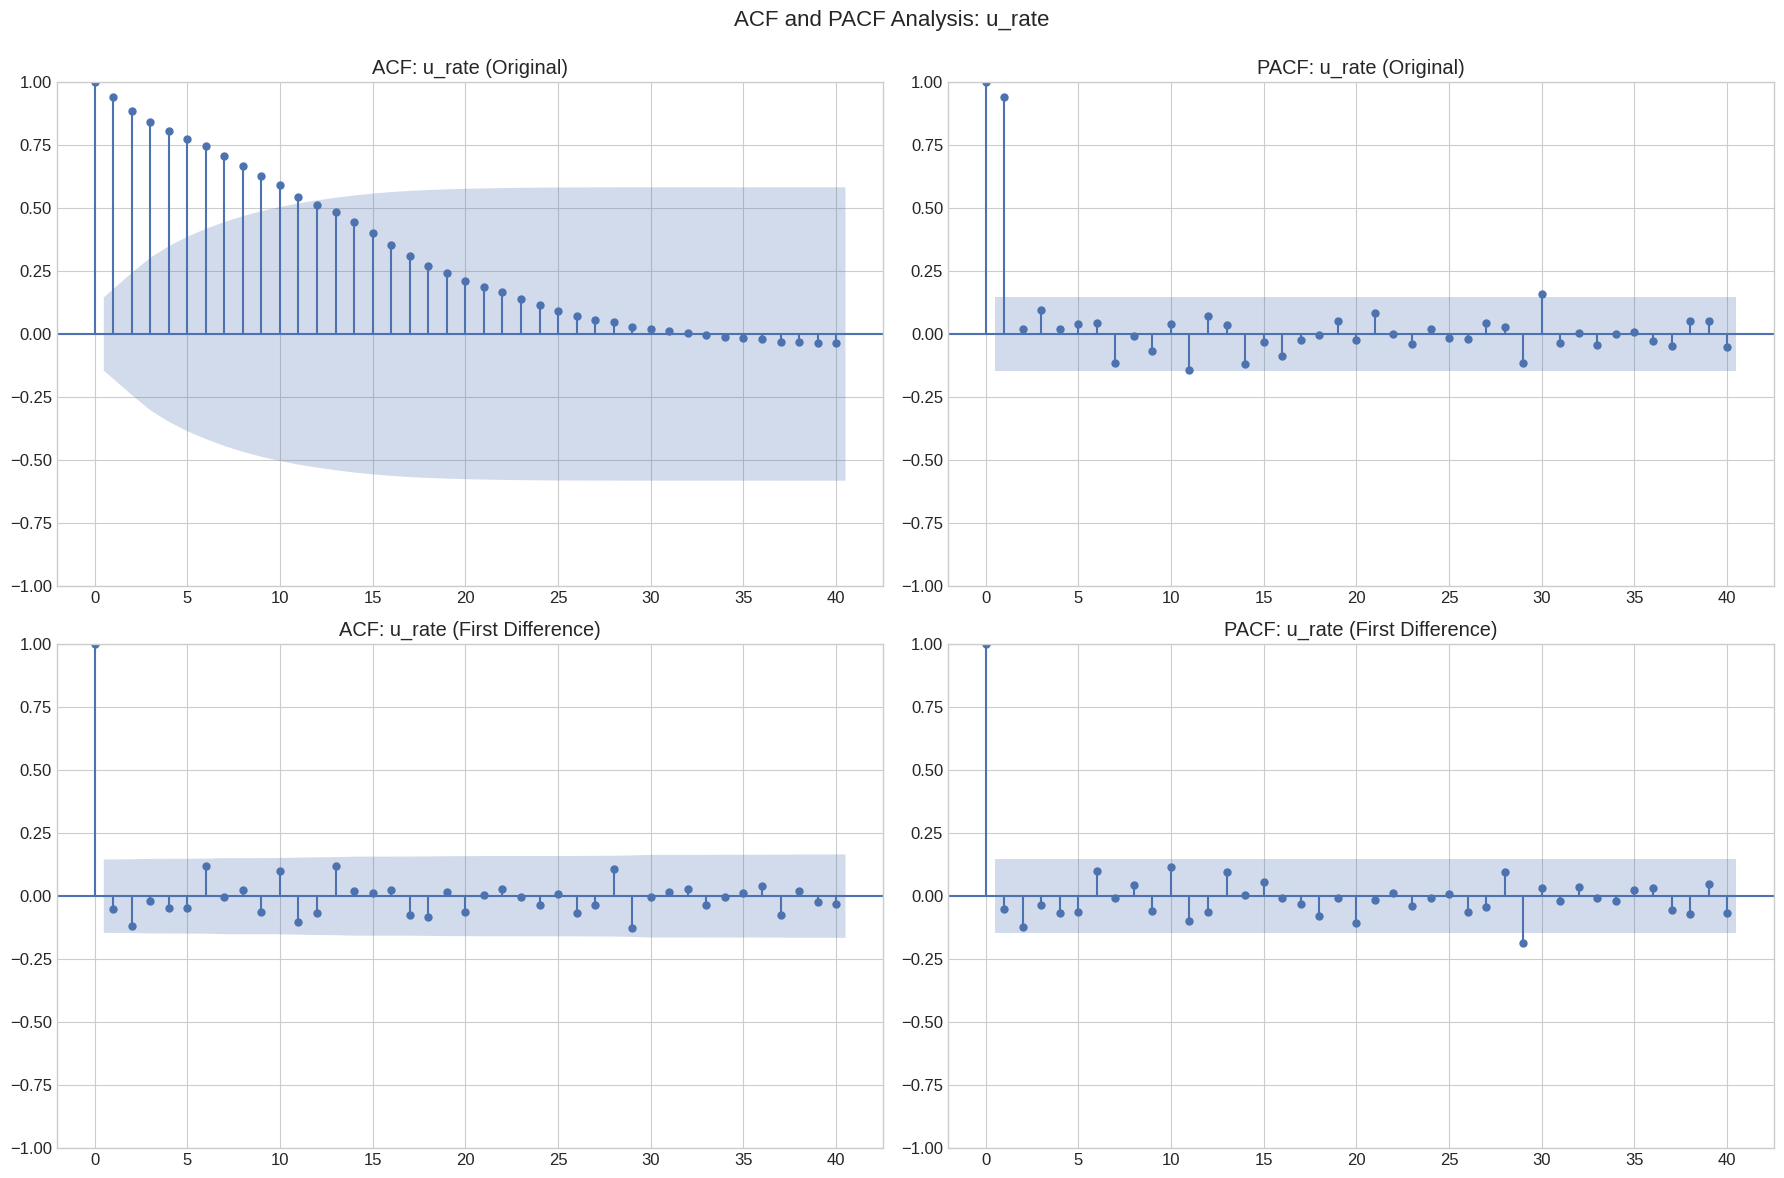


Significant lags in ACF (original series):
  Seasonal lags (multiples of 12): [12]
  All significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

Potential ARIMA/SARIMA parameters based on ACF/PACF:
  Suggested SARIMA(11,1,1)(P,D,Q,12)
  P, D, Q should be determined based on seasonal patterns
  Consider P=1 or Q=1 due to significant lag at 12


####################################################################################################
DETAILED STATISTICAL ANALYSIS FOR: Youth Unemployment
####################################################################################################

JARQUE-BERA TEST FOR NORMALITY
H0: Data is normally distributed
H1: Data is not normally distributed
--------------------------------------------------------------------------------
Variable                       JB Statistic    p-value         Skewness        Kurtosis        Conclusion          
-------------------------------------------------------

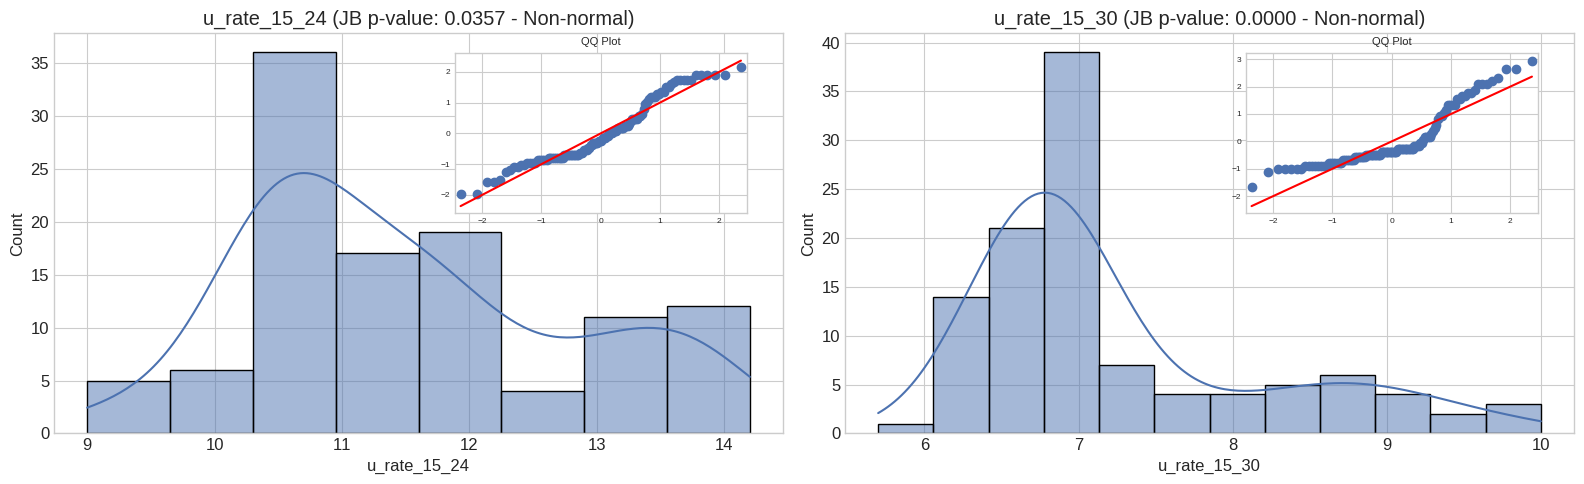


AUGMENTED DICKEY-FULLER TEST FOR STATIONARITY
H0: The time series has a unit root (non-stationary)
H1: The time series does not have a unit root (stationary)
--------------------------------------------------------------------------------
Variable                       ADF Statistic   p-value         Critical Value (1%)  Conclusion     
--------------------------------------------------------------------------------
u_rate_15_24                   -1.6565         0.4536          -3.4930              Non-stationary 
u_rate_15_30                   -2.1796         0.2137          -3.4918              Non-stationary 


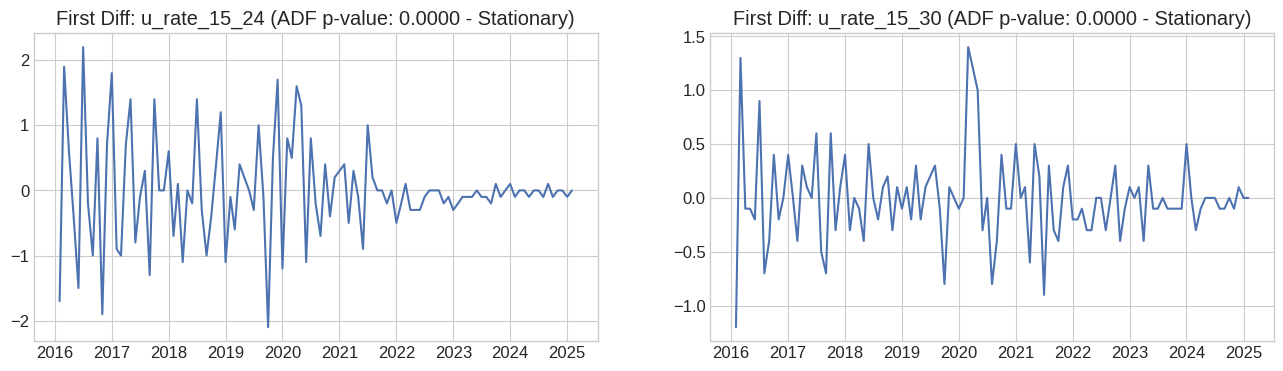

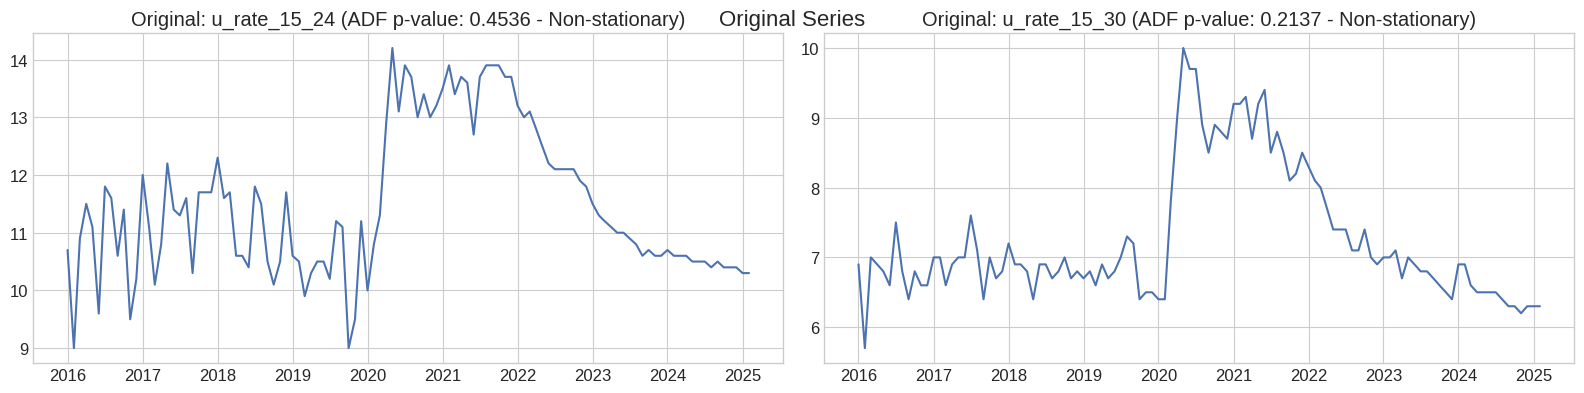

<Figure size 1400x800 with 0 Axes>


ACF AND PACF ANALYSIS

------------------------------------------------------------
Variable: u_rate_15_24
------------------------------------------------------------


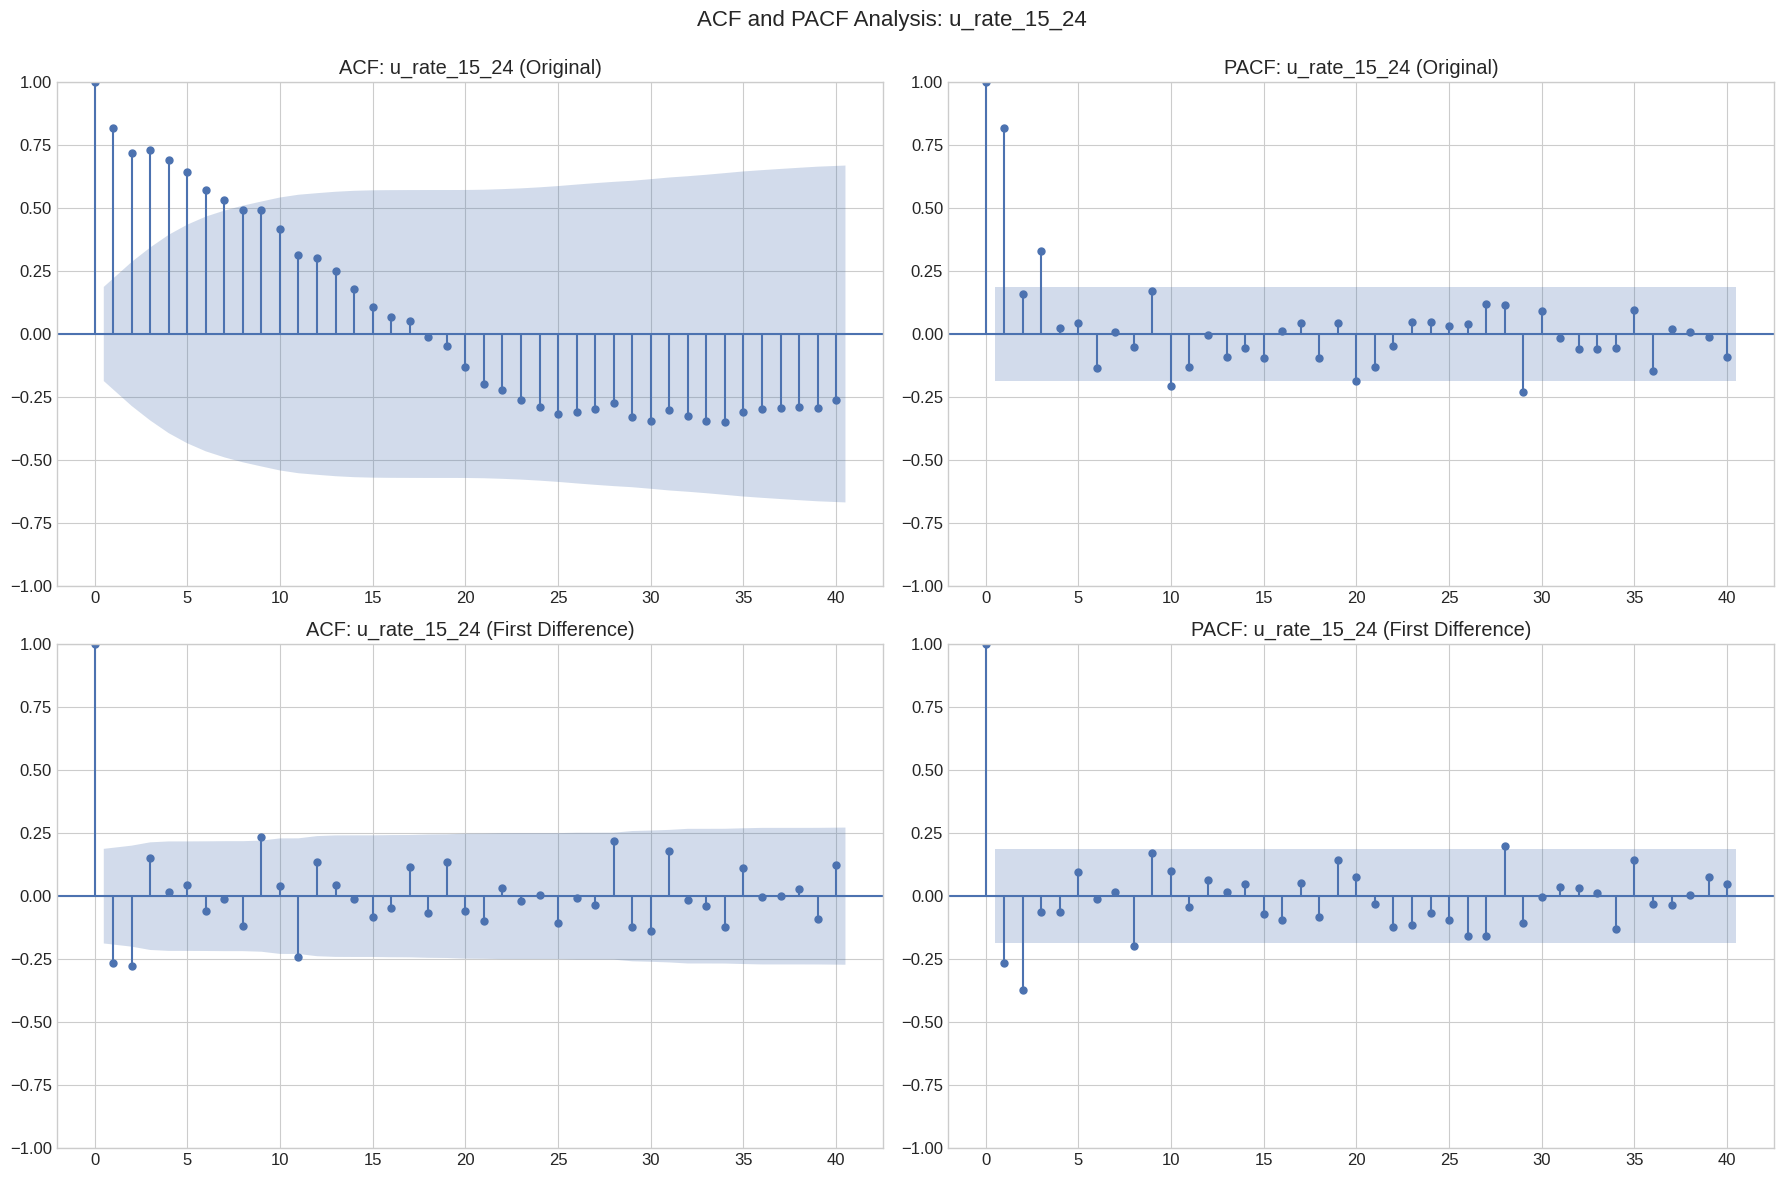


Significant lags in ACF (original series):
  Seasonal lags (multiples of 12): [12, 24, 36]
  All significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

Potential ARIMA/SARIMA parameters based on ACF/PACF:
  Suggested SARIMA(10,1,1)(P,D,Q,12)
  P, D, Q should be determined based on seasonal patterns
  Consider P=1 or Q=1 due to significant lag at 12
  Consider P=2 or Q=2 due to significant lag at 24

------------------------------------------------------------
Variable: u_rate_15_30
------------------------------------------------------------


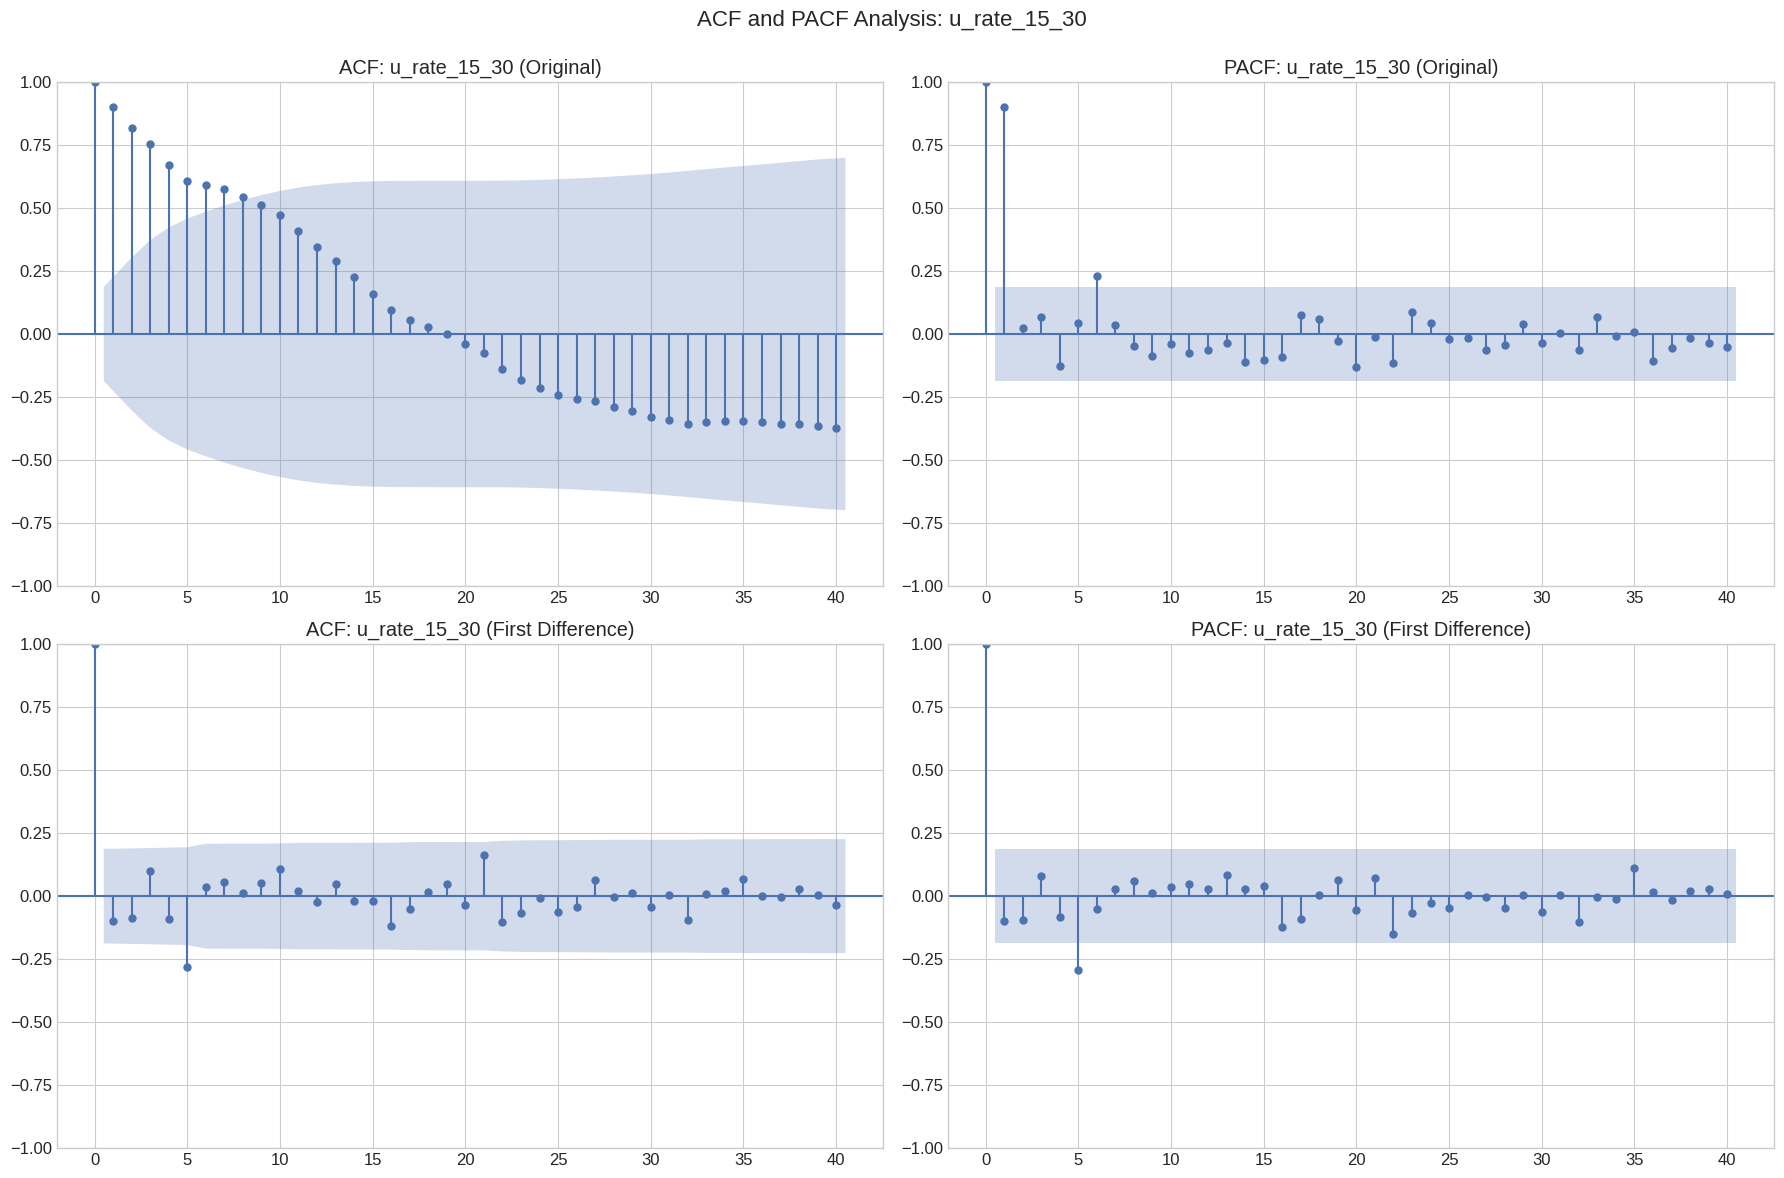


Significant lags in ACF (original series):
  Seasonal lags (multiples of 12): [12, 24, 36]
  All significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

Potential ARIMA/SARIMA parameters based on ACF/PACF:
  Suggested SARIMA(6,1,1)(P,D,Q,12)
  P, D, Q should be determined based on seasonal patterns
  Consider P=1 or Q=1 due to significant lag at 12
  Consider P=2 or Q=2 due to significant lag at 24


####################################################################################################
DETAILED STATISTICAL ANALYSIS FOR: Labor Force
####################################################################################################

JARQUE-BERA TEST FOR NORMALITY
H0: Data is normally distributed
H1: Data is not normally distributed
--------------------------------------------------------------------------------
Variable                       JB Statistic    p-value         Skewness        Kurto

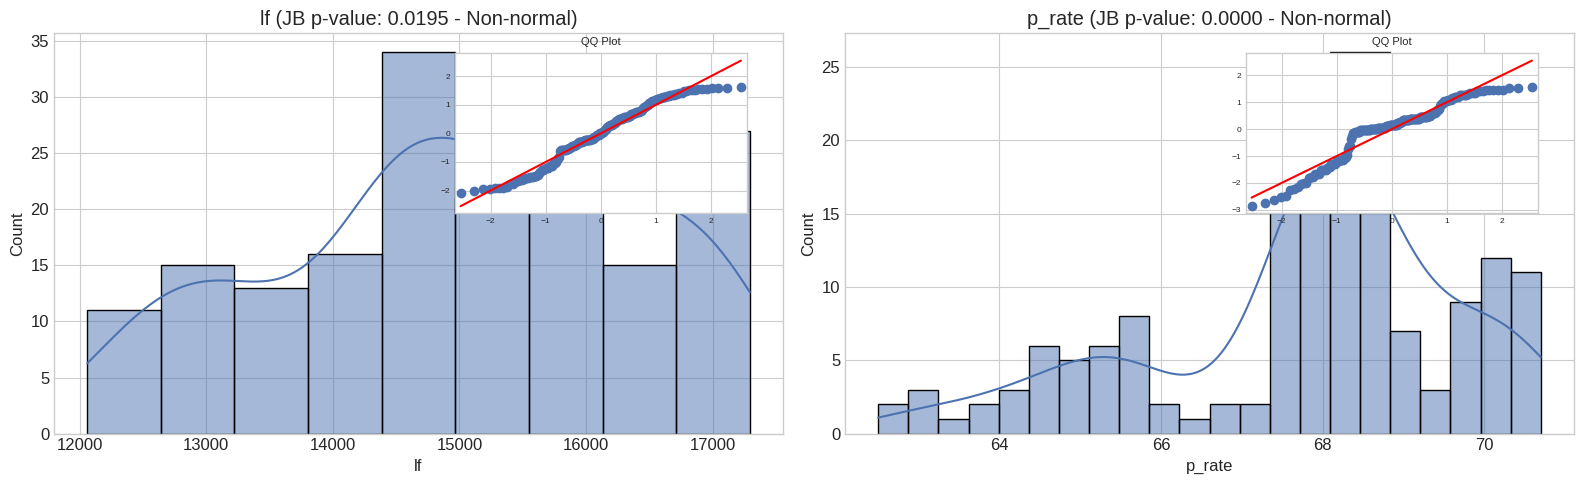


AUGMENTED DICKEY-FULLER TEST FOR STATIONARITY
H0: The time series has a unit root (non-stationary)
H1: The time series does not have a unit root (stationary)
--------------------------------------------------------------------------------
Variable                       ADF Statistic   p-value         Critical Value (1%)  Conclusion     
--------------------------------------------------------------------------------
lf                             -1.4731         0.5468          -3.4696              Non-stationary 
p_rate                         -1.7065         0.4278          -3.4701              Non-stationary 


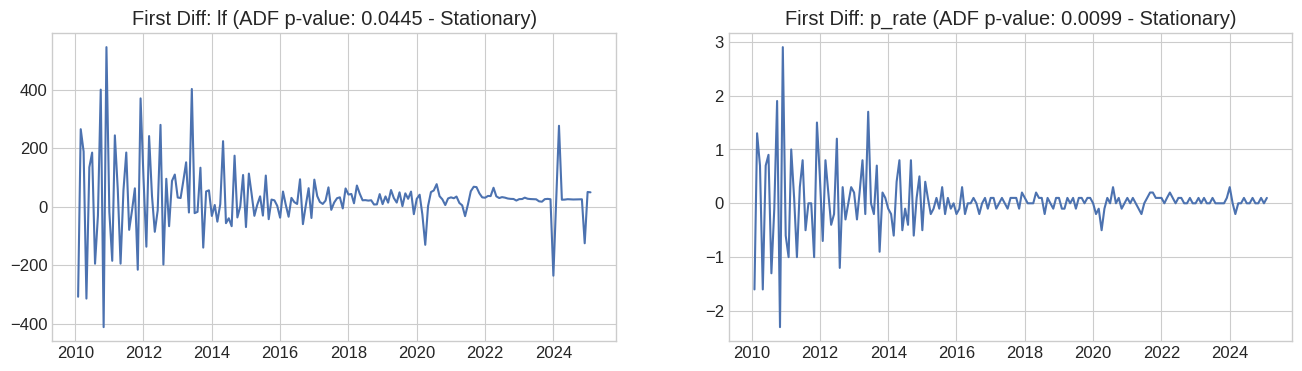

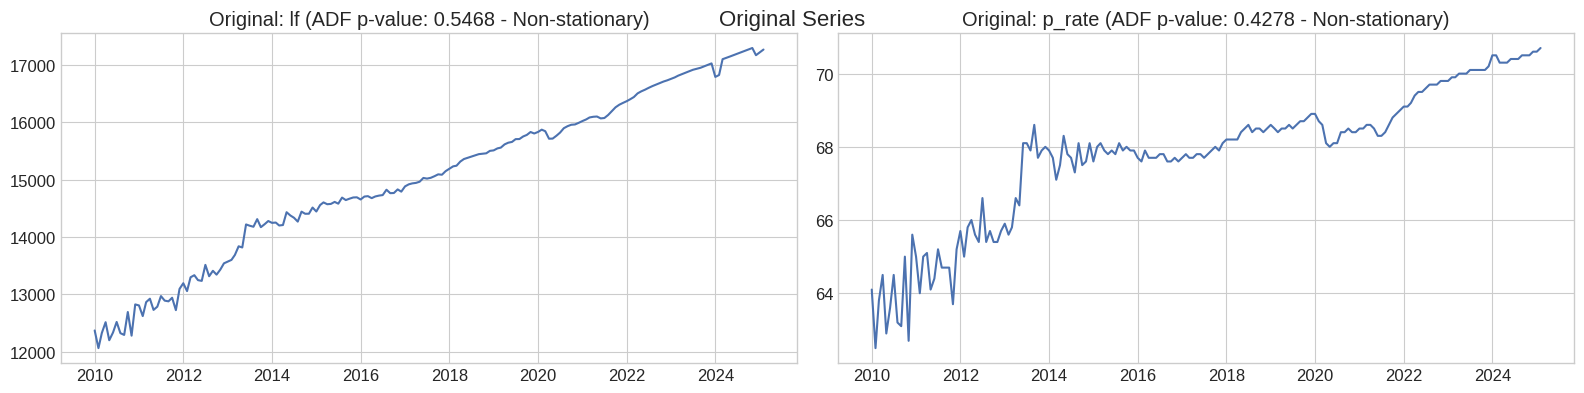

<Figure size 1400x800 with 0 Axes>


ACF AND PACF ANALYSIS

------------------------------------------------------------
Variable: lf
------------------------------------------------------------


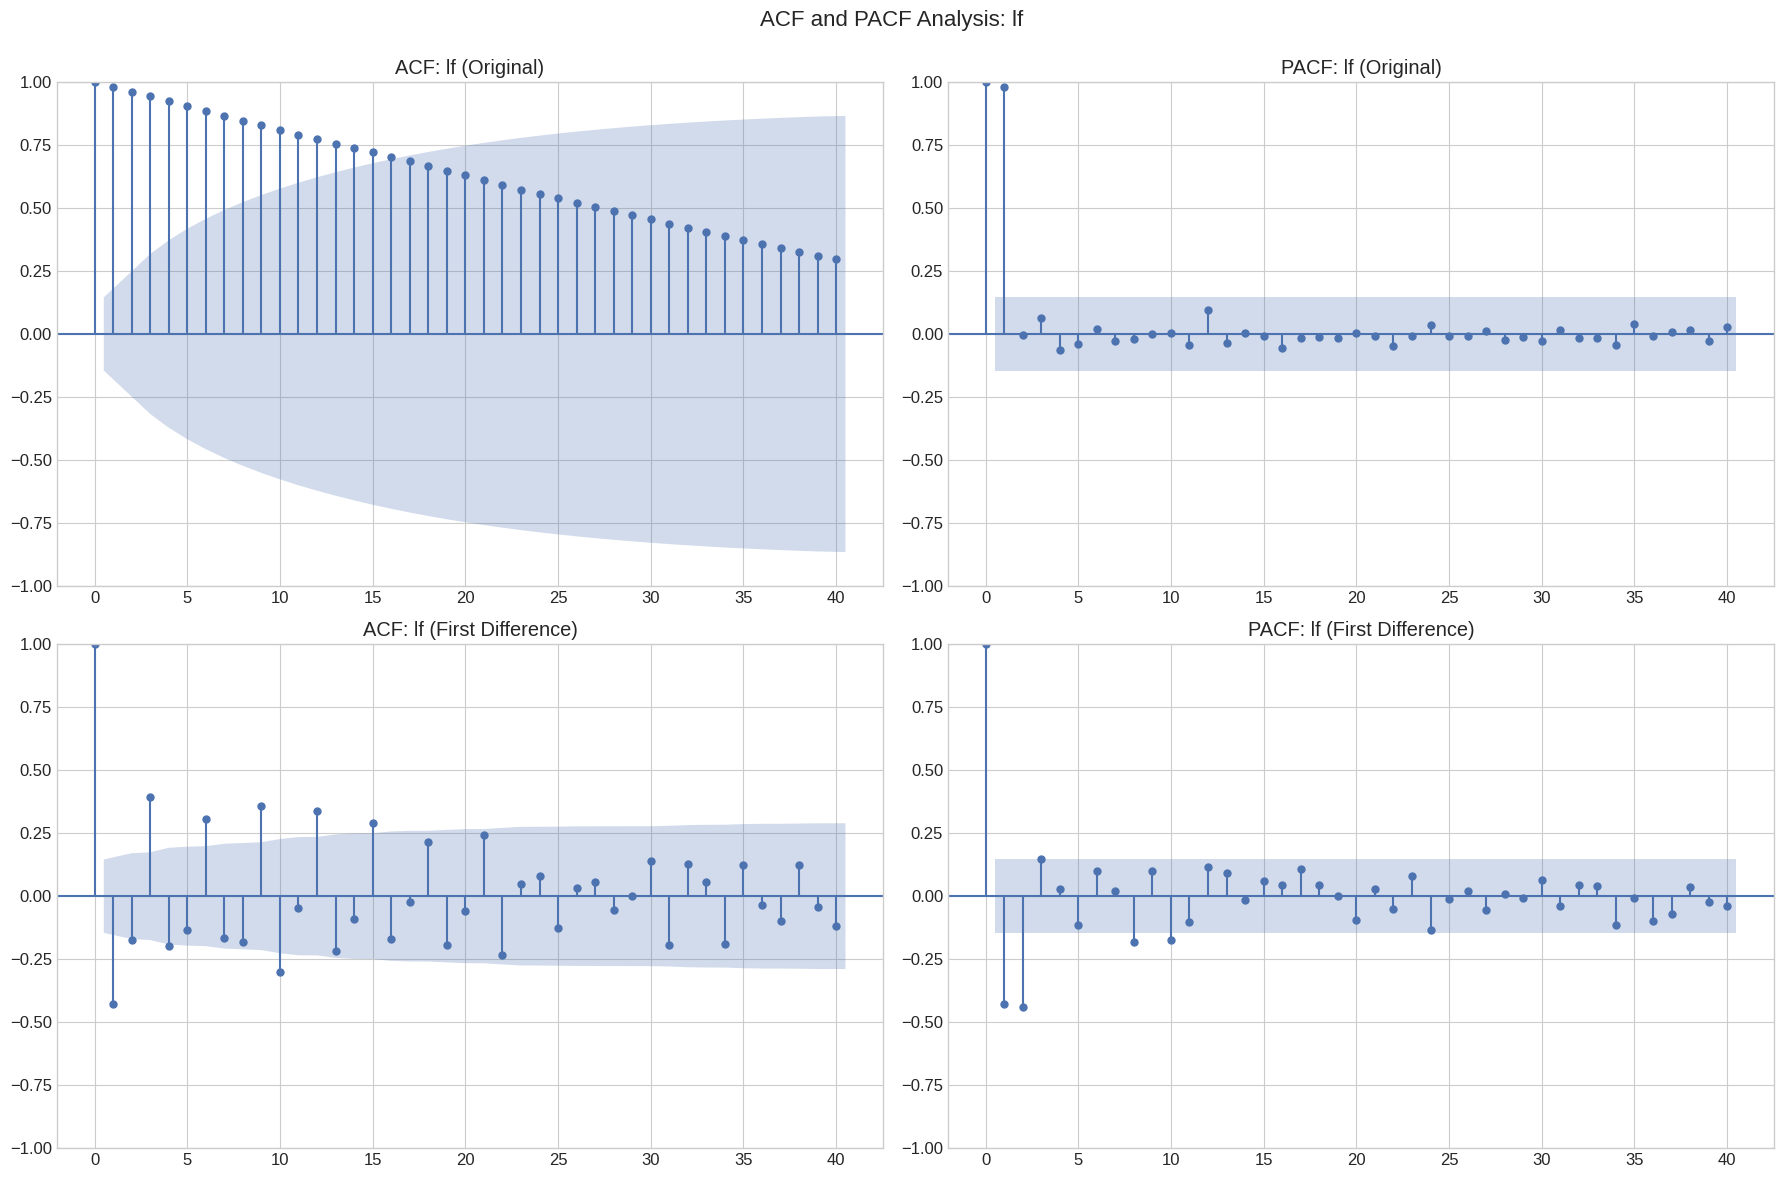


Significant lags in ACF (original series):
  Seasonal lags (multiples of 12): [12, 24, 36]
  All significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

Potential ARIMA/SARIMA parameters based on ACF/PACF:
  Suggested SARIMA(1,1,1)(P,D,Q,12)
  P, D, Q should be determined based on seasonal patterns
  Consider P=1 or Q=1 due to significant lag at 12
  Consider P=2 or Q=2 due to significant lag at 24

------------------------------------------------------------
Variable: p_rate
------------------------------------------------------------


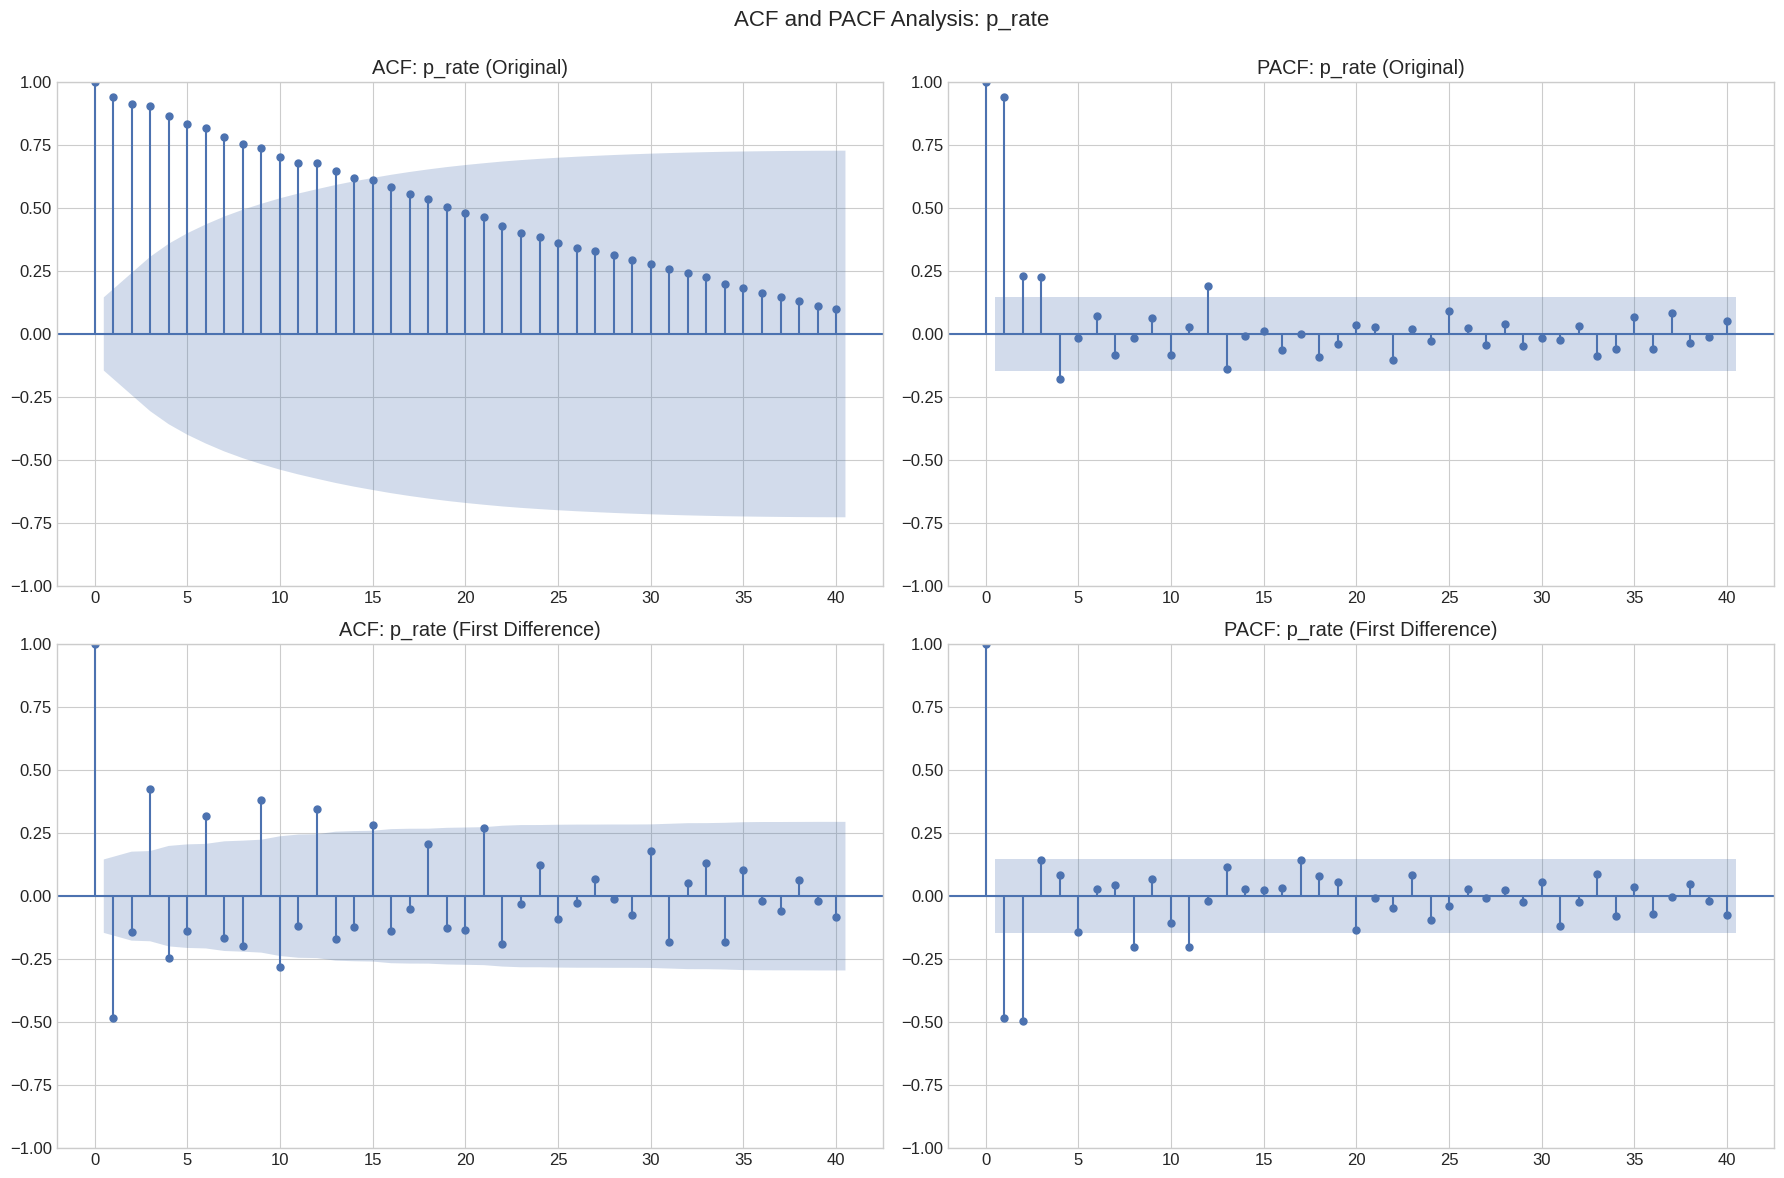


Significant lags in ACF (original series):
  Seasonal lags (multiples of 12): [12, 24, 36]
  All significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

Potential ARIMA/SARIMA parameters based on ACF/PACF:
  Suggested SARIMA(4,1,1)(P,D,Q,12)
  P, D, Q should be determined based on seasonal patterns
  Consider P=1 or Q=1 due to significant lag at 12
  Consider P=2 or Q=2 due to significant lag at 24


In [ ]:

import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def detailed_jarque_bera_test(df, columns=None):
    """
    Perform detailed Jarque-Bera test for normality on selected columns
    """
    if columns is None:
        columns = df.columns

    results = {}

    print(f"\n{'='*80}")
    print("JARQUE-BERA TEST FOR NORMALITY")
    print(f"{'='*80}")
    print("H0: Data is normally distributed")
    print("H1: Data is not normally distributed")
    print(f"{'-'*80}")
    print(f"{'Variable':<30} {'JB Statistic':<15} {'p-value':<15} {'Skewness':<15} {'Kurtosis':<15} {'Conclusion':<20}")
    print(f"{'-'*80}")

    # Create figure for visualization
    n_cols = min(2, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
    if n_rows * n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(columns):
        series = df[col].dropna()

        skew = stats.skew(series)
        kurtosis = stats.kurtosis(series, fisher=False)  
        n = len(series)
        jb_stat = n/6 * (skew**2 + (kurtosis-3)**2/4)
        jb_pvalue = 1 - stats.chi2.cdf(jb_stat, df=2)

        # Store results
        results[col] = {
            'jb_stat': jb_stat,
            'p_value': jb_pvalue,
            'skewness': skew,
            'kurtosis': kurtosis,
            'is_normal': jb_pvalue > 0.05
        }

        # Print results
        conclusion = "Normal" if jb_pvalue > 0.05 else "Non-normal"
        print(f"{col:<30} {jb_stat:<15.4f} {jb_pvalue:<15.4f} {skew:<15.4f} {kurtosis:<15.4f} {conclusion:<20}")

        # Plot histogram and QQ plot
        if i < len(axes):
            # Histogram
            sns.histplot(series, kde=True, ax=axes[i])
            axes[i].set_title(f"{col} (JB p-value: {jb_pvalue:.4f} - {conclusion})")

            # Add QQ plot as inset
            inset_ax = axes[i].inset_axes([0.55, 0.55, 0.4, 0.4])
            # Use statsmodels QQ plot function instead of scipy's probplot
            from statsmodels.graphics.gofplots import qqplot
            qqplot(series, line='s', ax=inset_ax, fit=True)
            inset_ax.set_title('QQ Plot', fontsize=8)
            inset_ax.tick_params(axis='both', which='major', labelsize=6)
            inset_ax.set_xlabel('')
            inset_ax.set_ylabel('')

    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return results

def detailed_adf_test(df, columns=None):
    """
    Perform detailed Augmented Dickey-Fuller test for stationarity on selected columns
    """
    if columns is None:
        columns = df.columns

    results = {}

    print(f"\n{'='*80}")
    print("AUGMENTED DICKEY-FULLER TEST FOR STATIONARITY")
    print(f"{'='*80}")
    print("H0: The time series has a unit root (non-stationary)")
    print("H1: The time series does not have a unit root (stationary)")
    print(f"{'-'*80}")
    print(f"{'Variable':<30} {'ADF Statistic':<15} {'p-value':<15} {'Critical Value (1%)':<20} {'Conclusion':<15}")
    print(f"{'-'*80}")

    # Create figure for visualization
    n_cols = min(2, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    if n_rows * n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # Also test first differences
    fig_diff, axes_diff = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    if n_rows * n_cols == 1:
        axes_diff = np.array([axes_diff])
    axes_diff = axes_diff.flatten() if isinstance(axes_diff, np.ndarray) else [axes_diff]

    for i, col in enumerate(columns):
        series = df[col].dropna()

        # ADF test on original series
        adf_result = adfuller(series)
        adf_stat = adf_result[0]
        p_value = adf_result[1]
        crit_value_1pct = adf_result[4]['1%']

        # Store results
        results[col] = {
            'adf_stat': adf_stat,
            'p_value': p_value,
            'critical_values': adf_result[4],
            'is_stationary': p_value < 0.05
        }

        # Print results
        conclusion = "Stationary" if p_value < 0.05 else "Non-stationary"
        print(f"{col:<30} {adf_stat:<15.4f} {p_value:<15.4f} {crit_value_1pct:<20.4f} {conclusion:<15}")

        # Plot original series and first difference
        if i < len(axes):
            # Original series
            axes[i].plot(series.index, series.values)
            axes[i].set_title(f"Original: {col} (ADF p-value: {p_value:.4f} - {conclusion})")
            axes[i].grid(True)

            # First difference
            diff_series = series.diff().dropna()
            diff_result = adfuller(diff_series)
            diff_p_value = diff_result[1]
            diff_conclusion = "Stationary" if diff_p_value < 0.05 else "Non-stationary"

            axes_diff[i].plot(diff_series.index, diff_series.values)
            axes_diff[i].set_title(f"First Diff: {col} (ADF p-value: {diff_p_value:.4f} - {diff_conclusion})")
            axes_diff[i].grid(True)

    for j in range(len(columns), len(axes)):
        if j < len(axes):
            fig.delaxes(axes[j])
        if j < len(axes_diff):
            fig_diff.delaxes(axes_diff[j])

    plt.figure(fig.number)
    plt.tight_layout()
    plt.suptitle("Original Series", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

    plt.figure(fig_diff.number)
    plt.tight_layout()
    plt.suptitle("First Differenced Series", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

    return results

def detailed_acf_pacf_analysis(df, columns=None, max_lags=40):
    """
    Create detailed ACF and PACF plots for selected columns
    """
    if columns is None:
        columns = df.columns

    results = {}

    print(f"\n{'='*80}")
    print("ACF AND PACF ANALYSIS")
    print(f"{'='*80}")

    for col in columns:
        series = df[col].dropna()

        print(f"\n{'-'*60}")
        print(f"Variable: {col}")
        print(f"{'-'*60}")

        # Create figure
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))

        # Original series
        # ACF
        plot_acf(series, lags=max_lags, ax=axes[0, 0])
        axes[0, 0].set_title(f"ACF: {col} (Original)")
        axes[0, 0].grid(True)

        # PACF
        plot_pacf(series, lags=max_lags, ax=axes[0, 1])
        axes[0, 1].set_title(f"PACF: {col} (Original)")
        axes[0, 1].grid(True)

        # First difference
        diff_series = series.diff().dropna()

        # ACF of differenced series
        plot_acf(diff_series, lags=max_lags, ax=axes[1, 0])
        axes[1, 0].set_title(f"ACF: {col} (First Difference)")
        axes[1, 0].grid(True)

        # PACF of differenced series
        plot_pacf(diff_series, lags=max_lags, ax=axes[1, 1])
        axes[1, 1].set_title(f"PACF: {col} (First Difference)")
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.suptitle(f"ACF and PACF Analysis: {col}", fontsize=16)
        plt.subplots_adjust(top=0.92)
        plt.show()

        # Seasonal patterns (focus on multiples of 12 for monthly data)
        print("\nSignificant lags in ACF (original series):")
        significant_lags = []

        acf_x = np.arange(max_lags + 1)
        acf_y = sm.tsa.stattools.acf(series, nlags=max_lags)
        confidence_interval = 1.96 / np.sqrt(len(series))

        for lag in range(1, max_lags + 1):
            if abs(acf_y[lag]) > confidence_interval:
                significant_lags.append(lag)

        # Focus on seasonal patterns
        seasonal_lags = [lag for lag in significant_lags if lag % 12 == 0]
        if seasonal_lags:
            print(f"  Seasonal lags (multiples of 12): {seasonal_lags}")

        # Get potential AR and MA orders from PACF and ACF
        pacf_y = sm.tsa.stattools.pacf(series, nlags=max_lags)

        # Potential AR order (from PACF)
        ar_lags = []
        for lag in range(1, max_lags + 1):
            if abs(pacf_y[lag]) > confidence_interval:
                ar_lags.append(lag)

        # Store results
        results[col] = {
            'significant_acf_lags': significant_lags,
            'seasonal_lags': seasonal_lags,
            'potential_ar_lags': ar_lags
        }

        print(f"  All significant lags: {significant_lags}")

        # Seasonal components
        if any(lag % 12 == 0 for lag in significant_lags):
            print(f"  Suggested SARIMA({p_suggestion},{d_suggestion},{q_suggestion})(P,D,Q,12)")
            print("  P, D, Q should be determined based on seasonal patterns")
            if 12 in significant_lags:
                print("  Consider P=1 or Q=1 due to significant lag at 12")
            if 24 in significant_lags:
                print("  Consider P=2 or Q=2 due to significant lag at 24")
        else:
            print(f"  Suggested ARIMA({p_suggestion},{d_suggestion},{q_suggestion})")

    return results

key_series = {
    'Overall Unemployment': lfs_month_ts[['u_rate']],
    'Youth Unemployment': lfs_month_youth_ts[['u_rate_15_24', 'u_rate_15_30']],
    'Labor Force': lfs_month_ts[['lf', 'p_rate']]
}

# Run tests for each dataset
for name, df in key_series.items():
    print(f"\n\n{'#'*100}")
    print(f"DETAILED STATISTICAL ANALYSIS FOR: {name}")
    print(f"{'#'*100}")

    # Jarque-Bera test
    jb_results = detailed_jarque_bera_test(df)

    # ADF test
    adf_results = detailed_adf_test(df)

    # ACF and PACF analysis
    acf_pacf_results = detailed_acf_pacf_analysis(df)

## Anderson-Darling Test for Normality



####################################################################################################
ANDERSON-DARLING NORMALITY ANALYSIS FOR: Overall Unemployment
####################################################################################################

ANDERSON-DARLING TEST FOR NORMALITY
H0: Data is drawn from a normal distribution
H1: Data is not drawn from a normal distribution
--------------------------------------------------------------------------------
Variable                       A^2 Statistic   Critical Values (15%, 10%, 5%, 2.5%, 1%)      Significance Level   Conclusion     
--------------------------------------------------------------------------------
u_rate                         13.4816         0.564, 0.642, 0.771, 0.899, 1.069             < 1.0                Non-normal     


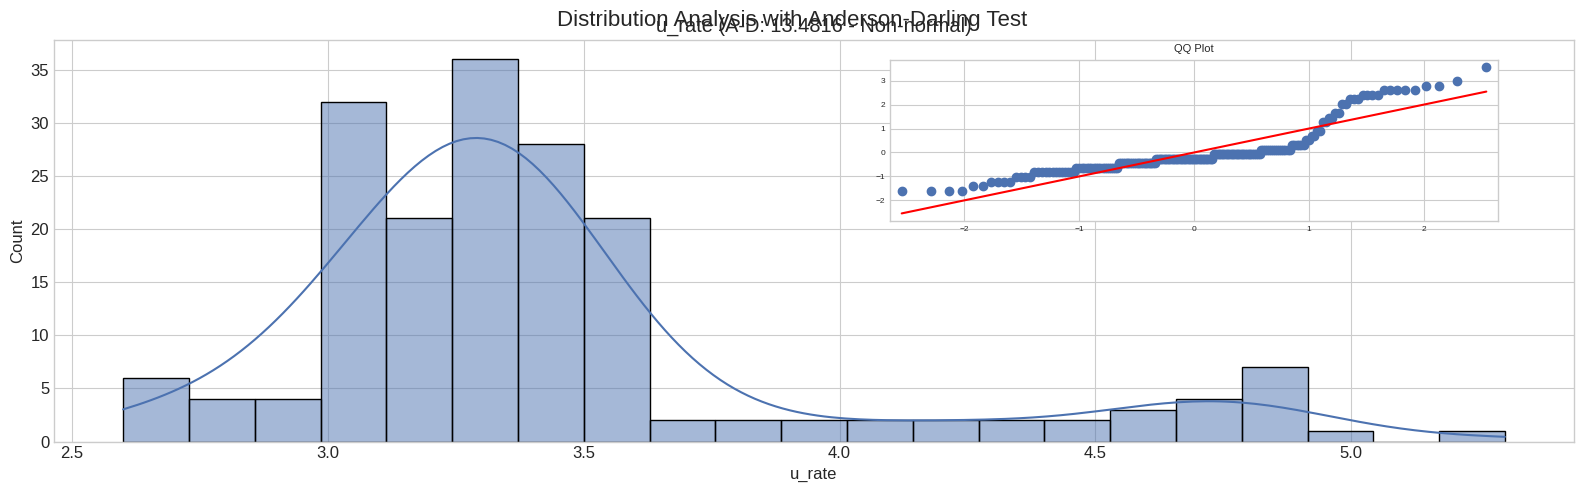


COMPARISON OF NORMALITY TESTS
Variable                       Anderson-Darling     Jarque-Bera          Shapiro-Wilk         Agreement 
----------------------------------------------------------------------------------------------------
u_rate                         Non-normal           Non-normal           Non-normal           Yes       


####################################################################################################
ANDERSON-DARLING NORMALITY ANALYSIS FOR: Youth Unemployment
####################################################################################################

ANDERSON-DARLING TEST FOR NORMALITY
H0: Data is drawn from a normal distribution
H1: Data is not drawn from a normal distribution
--------------------------------------------------------------------------------
Variable                       A^2 Statistic   Critical Values (15%, 10%, 5%, 2.5%, 1%)      Significance Level   Conclusion     
----------------------------------------------------

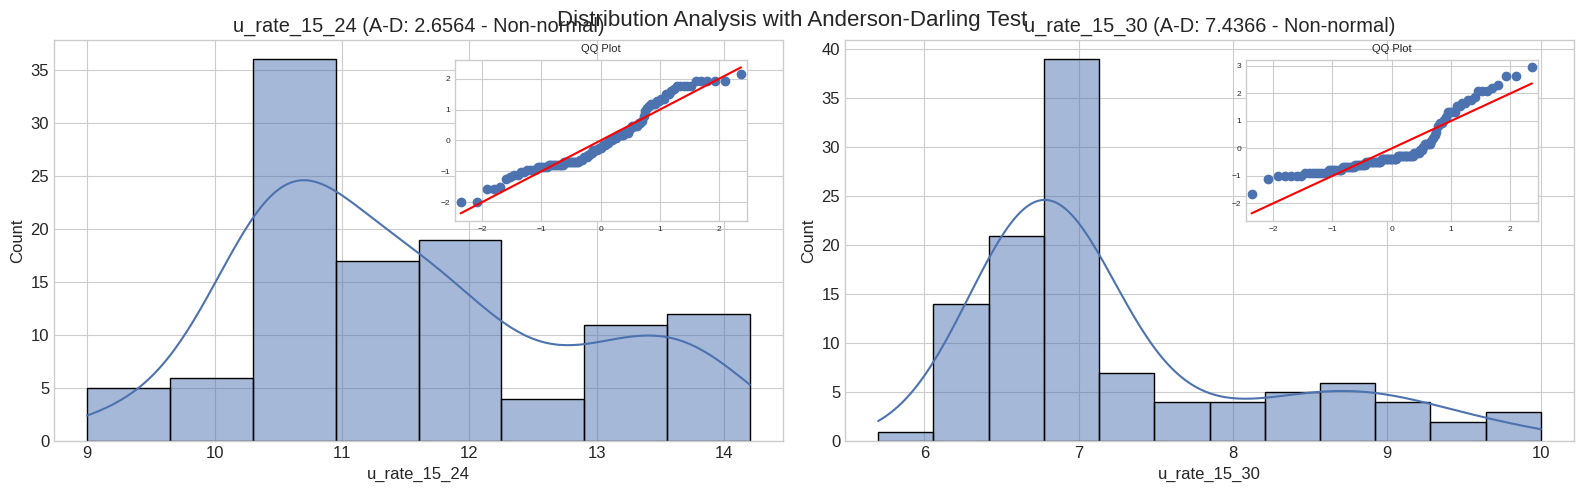


COMPARISON OF NORMALITY TESTS
Variable                       Anderson-Darling     Jarque-Bera          Shapiro-Wilk         Agreement 
----------------------------------------------------------------------------------------------------
u_rate_15_24                   Non-normal           Non-normal           Non-normal           Yes       
u_rate_15_30                   Non-normal           Non-normal           Non-normal           Yes       


####################################################################################################
ANDERSON-DARLING NORMALITY ANALYSIS FOR: Labor Force
####################################################################################################

ANDERSON-DARLING TEST FOR NORMALITY
H0: Data is drawn from a normal distribution
H1: Data is not drawn from a normal distribution
--------------------------------------------------------------------------------
Variable                       A^2 Statistic   Critical Values (15%, 10%, 5%, 2.5%, 

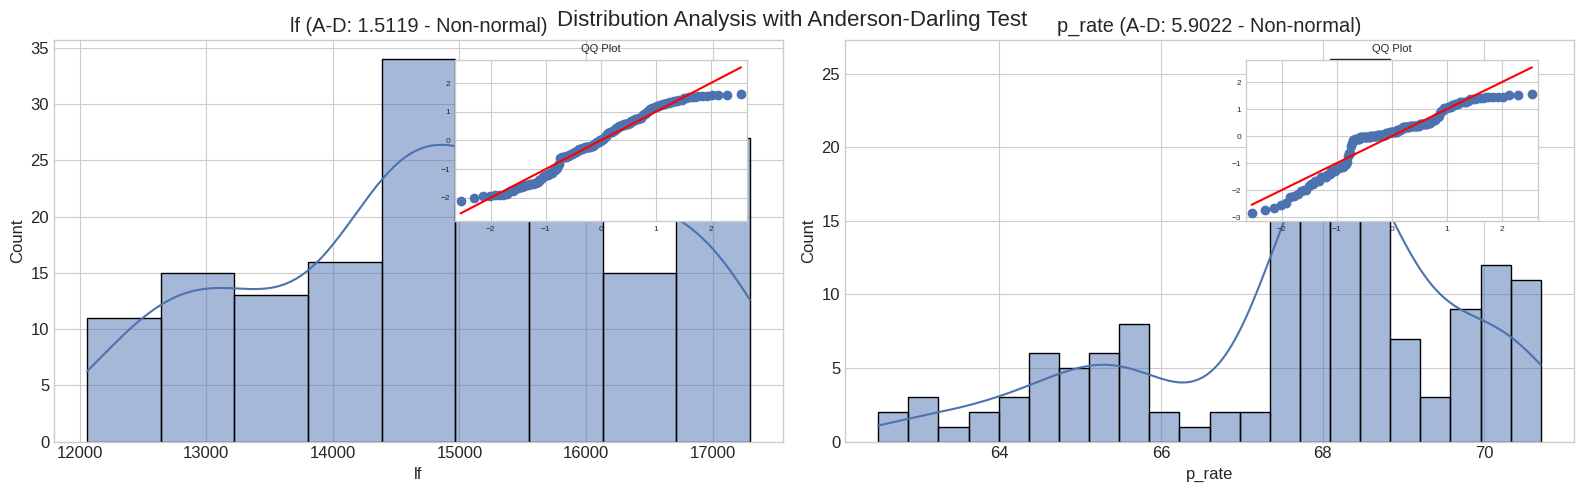


COMPARISON OF NORMALITY TESTS
Variable                       Anderson-Darling     Jarque-Bera          Shapiro-Wilk         Agreement 
----------------------------------------------------------------------------------------------------
lf                             Non-normal           Non-normal           Non-normal           Yes       
p_rate                         Non-normal           Non-normal           Non-normal           Yes       


In [ ]:

from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def anderson_darling_test(df, columns=None):
    if columns is None:
        columns = df.columns

    results = {}

    print(f"\n{'='*80}")
    print("ANDERSON-DARLING TEST FOR NORMALITY")
    print(f"{'='*80}")
    print("H0: Data is drawn from a normal distribution")
    print("H1: Data is not drawn from a normal distribution")
    print(f"{'-'*80}")
    print(f"{'Variable':<30} {'A^2 Statistic':<15} {'Critical Values (15%, 10%, 5%, 2.5%, 1%)':<45} {'Significance Level':<20} {'Conclusion':<15}")
    print(f"{'-'*80}")

    # Create figure for visualization
    n_cols = min(2, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
    if n_rows * n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(columns):
        series = df[col].dropna()

        # Anderson-Darling test
        ad_result = stats.anderson(series, dist='norm')
        ad_stat = ad_result.statistic
        crit_values = ad_result.critical_values
        significance_levels = [15.0, 10.0, 5.0, 2.5, 1.0]  

        # Determine significance level
        significance_level = None
        for sig_level, crit_value in zip(significance_levels, crit_values):
            if ad_stat < crit_value:
                significance_level = sig_level
                break

        if significance_level is None:
            significance_level = "< 1.0"

      
        if ad_stat > crit_values[2]:  # Using 5% significance level for conclusion
            conclusion = "Non-normal"
        else:
            conclusion = "Normal"

        # Store results
        results[col] = {
            'ad_stat': ad_stat,
            'critical_values': crit_values,
            'significance_level': significance_level,
            'is_normal': conclusion == "Normal"
        }

        # Print results
        crit_values_str = f"{crit_values[0]:.3f}, {crit_values[1]:.3f}, {crit_values[2]:.3f}, {crit_values[3]:.3f}, {crit_values[4]:.3f}"
        print(f"{col:<30} {ad_stat:<15.4f} {crit_values_str:<45} {significance_level:<20} {conclusion:<15}")

        # Plot histogram and normal probability plot
        if i < len(axes):
            # Create subplot for visual analysis
            sns.histplot(series, kde=True, ax=axes[i])
            axes[i].set_title(f"{col} (A-D: {ad_stat:.4f} - {conclusion})")

            # Add QQ plot as inset
            inset_ax = axes[i].inset_axes([0.55, 0.55, 0.4, 0.4])
            # Use statsmodels QQ plot function
            from statsmodels.graphics.gofplots import qqplot
            qqplot(series, line='s', ax=inset_ax, fit=True)
            inset_ax.set_title('QQ Plot', fontsize=8)
            inset_ax.tick_params(axis='both', which='major', labelsize=6)
            # Remove labels for cleaner appearance in the inset
            inset_ax.set_xlabel('')
            inset_ax.set_ylabel('')

    # Hide empty subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("Distribution Analysis with Anderson-Darling Test", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

    # Compare with other normality tests
    print(f"\n{'='*80}")
    print("COMPARISON OF NORMALITY TESTS")
    print(f"{'='*80}")
    print(f"{'Variable':<30} {'Anderson-Darling':<20} {'Jarque-Bera':<20} {'Shapiro-Wilk':<20} {'Agreement':<10}")
    print(f"{'-'*100}")

    for col in columns:
        series = df[col].dropna()

        # Anderson-Darling result (already calculated)
        ad_conclusion = results[col]['is_normal']

        # Jarque-Bera test
        jb_stat, jb_pvalue = stats.jarque_bera(series)
        jb_conclusion = jb_pvalue > 0.05

        # Shapiro-Wilk test
        sw_stat, sw_pvalue = stats.shapiro(series)
        sw_conclusion = sw_pvalue > 0.05

        tests = [ad_conclusion, jb_conclusion, sw_conclusion]
        agreement = "Yes" if all(x == tests[0] for x in tests) else "No"

        # Print comparison
        print(f"{col:<30} {'Normal' if ad_conclusion else 'Non-normal':<20} {'Normal' if jb_conclusion else 'Non-normal':<20} {'Normal' if sw_conclusion else 'Non-normal':<20} {agreement:<10}")

    return results

key_series = {
    'Overall Unemployment': lfs_month_ts[['u_rate']],
    'Youth Unemployment': lfs_month_youth_ts[['u_rate_15_24', 'u_rate_15_30']],
    'Labor Force': lfs_month_ts[['lf', 'p_rate']]
}

# Run tests for each dataset
for name, df in key_series.items():
    print(f"\n\n{'#'*100}")
    print(f"ANDERSON-DARLING NORMALITY ANALYSIS FOR: {name}")
    print(f"{'#'*100}")

    # Anderson-Darling test
    ad_results = anderson_darling_test(df)